In [1]:
import openmc
import numpy as np

In [2]:
#this is a model of a BCC lattice unit cell with a reflecting boundary

In [3]:
#materials
#these are functionally dummy values until you have a chance to look everything up.  note to self - include sources in comments.
#also doublecheck isotopic compostions conventions in mats
uco = openmc.Material(name='UCO')
uco.set_density('kg/m3', 1.0)
#you might also be able to do this more cleanly with the enrichment options add_element has
uco.add_nuclide('U235', 4.6716e-02, percent_type='ao')#'wo' is for weight percent
uco.add_nuclide('U238', 2.8697e-01, percent_type='ao')#'wo' is for weight percent
uco.add_nuclide('O16',  5.0000e-01, percent_type='ao')#'wo' is for weight percent
uco.add_element('C', 1.6667e-01)

buffer = openmc.Material(name='buffer')
buffer.set_density('kg/m3', 1.0)
buffer.add_element('C', 1.0)
buffer.add_s_alpha_beta('c_Graphite')

pyc = openmc.Material(name='PyC')
pyc.set_density('kg/m3', 1.0)
pyc.add_element('C', 1.0)
pyc.add_s_alpha_beta('c_Graphite')

sic = openmc.Material(name='SiC')
sic.set_density('kg/m3', 1.0)
sic.add_element('C', 0.5)
sic.add_element('Si', 0.5)
sic.add_s_alpha_beta('c_Graphite')

graphite = openmc.Material(name='graphite')
graphite.set_density('kg/m3', 1.0)
graphite.add_element('C', 1.0)
graphite.add_s_alpha_beta('c_Graphite')

he = openmc.Material(name='He')
he.set_density('atom/b-cm', 0.0006)
he.add_element('He', 1.0)

In [4]:
#geometry parameters - remember LAMMPS coords are in meters, this is in cm
#remember, triso order: kernel, buffer, pyc, sic, pyc
peb_or = 3.0 #outer radius of whole pebble
peb_ir = 2.5 # radius of the region that has trisos in it only
triso_r = [0.02125, 0.03125, 0.03525, 0.03875, 0.04275]
bcc_l = (4*peb_or)/(3**(0.5))

In [5]:
#define the edges of the unit cell
bcc_min_x = openmc.XPlane(x0=-0.5*bcc_l, boundary_type='reflective')
bcc_max_x = openmc.XPlane(x0=0.5*bcc_l, boundary_type='reflective')
bcc_min_y = openmc.YPlane(y0=-0.5*bcc_l, boundary_type='reflective')
bcc_max_y = openmc.YPlane(y0=0.5*bcc_l, boundary_type='reflective')
bcc_min_z = openmc.ZPlane(z0=-0.5*bcc_l, boundary_type='reflective')
bcc_max_z = openmc.ZPlane(z0=0.5*bcc_l, boundary_type='reflective')

In [6]:
#define the cells and universe for the triso particles
triso_bounds = [openmc.Sphere(r=r) for r in triso_r[:-1]]
triso_cells = [openmc.Cell(fill=uco, region=-triso_bounds[0]),
               openmc.Cell(fill=buffer, region=+triso_bounds[0] & -triso_bounds[1]),
               openmc.Cell(fill=pyc, region=+triso_bounds[1] & -triso_bounds[2]),
               openmc.Cell(fill=sic, region=+triso_bounds[2] & -triso_bounds[3]),
               openmc.Cell(fill=pyc, region=+triso_bounds[3])]
triso_univ = openmc.Universe(cells=triso_cells)

In [7]:
# define where the particles will be packed
# BCC lattice has one sphere at the center, and a 1/4 sphere at each corner, tight enough they are all touching.
#that part should be handled with your calculation of the cube length (the body diameter = 2 peb diameters)

#start with the easy part: the center pebble

body_peb_in = openmc.Sphere(r = peb_ir)
body_wfuel_bound = -body_peb_in
body_peb_out = openmc.Sphere(r=peb_or)
body_nofuel_reg = -body_peb_out & +body_peb_in

#remember, this is the fueled part only, so it uses peb_ir.  Center the BCC at 0.
#generate the triso centers in the body pebble:

body_centers = openmc.model.pack_spheres(triso_r[-1], region=body_wfuel_bound, num_spheres=19000, seed = 978397880)
body_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in body_centers]

#now define the no-fueled outer shell for the body peb

body_wfuel = openmc.Cell(region=body_wfuel_bound)
lower_left, upper_right = body_wfuel.region.bounding_box
shape = (10, 10, 10)
pitch = (upper_right - lower_left)/shape
body_lattice = openmc.model.create_triso_lattice(
    body_trisos, lower_left, pitch, shape, graphite)

body_wfuel.fill = body_lattice
body_nofuel = openmc.Cell(fill=graphite, region=body_nofuel_reg)

body_cells = [body_wfuel, body_nofuel]


In [8]:
#this will follow the same basic steps as the center pebble.  initial triso definition shouldn't change.
#this one is the -1,-1,-1 corner
c1_peb_in = openmc.Sphere(x0 = -0.5*bcc_l, y0 =-0.5*bcc_l, z0 =-0.5*bcc_l, r = peb_ir)
c1_peb_out = openmc.Sphere(x0 = -0.5*bcc_l, y0 =-0.5*bcc_l, z0 =-0.5*bcc_l,r = peb_or)
c1_corner_bound = +bcc_min_x & +bcc_min_y & +bcc_min_z
c1_wfuel_reg = -c1_peb_in & c1_corner_bound
c1_nofuel_reg = -c1_peb_out & +c1_peb_in & c1_corner_bound

c1_centers = openmc.model.pack_spheres(triso_r[-1], region=-c1_peb_in, num_spheres=19000, seed = 987432789)
c1_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c1_centers]

c1_wfuel = openmc.Cell(region=c1_wfuel_reg)
lower_left, upper_right = c1_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c1_lattice = openmc.model.create_triso_lattice(
    c1_trisos, lower_left, pitch, shape, graphite)

c1_wfuel.fill = c1_lattice
c1_nofuel = openmc.Cell(fill=graphite, region=c1_nofuel_reg)

c1_cells = [c1_wfuel, c1_nofuel]

/home/zoe/anaconda3/envs/ghastly-dev/lib/python3.11/site-packages/openmc/model/triso.py:850: UserWarning: TRISO particle is partially or completely outside of the lattice.
  warnings.warn('TRISO particle is partially or completely '


In [9]:
#c2: -1,-1,1
c2_peb_in = openmc.Sphere(x0 = -0.5*bcc_l, y0 =-0.5*bcc_l, z0 =0.5*bcc_l, r = peb_ir)
c2_peb_out = openmc.Sphere(x0 = -0.5*bcc_l, y0 =-0.5*bcc_l, z0 =0.5*bcc_l,r = peb_or)
c2_corner_bound = +bcc_min_x & +bcc_min_y & -bcc_max_z
c2_wfuel_reg = -c2_peb_in & c2_corner_bound
c2_nofuel_reg = -c2_peb_out & +c2_peb_in & c2_corner_bound

c2_centers = openmc.model.pack_spheres(triso_r[-1], region=-c2_peb_in, num_spheres=19000, seed = 895490889)
c2_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c2_centers]

c2_wfuel = openmc.Cell(region=c2_wfuel_reg)
lower_left, upper_right = c2_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c2_lattice = openmc.model.create_triso_lattice(
    c2_trisos, lower_left, pitch, shape, graphite)

c2_wfuel.fill = c2_lattice
c2_nofuel = openmc.Cell(fill=graphite, region=c2_nofuel_reg)

c2_cells = [c2_wfuel, c2_nofuel]

In [10]:
#c3: -1, 1, -1
c3_peb_in = openmc.Sphere(x0 = -0.5*bcc_l, y0 =0.5*bcc_l, z0 =-0.5*bcc_l, r = peb_ir)
c3_peb_out = openmc.Sphere(x0 = -0.5*bcc_l, y0 =0.5*bcc_l, z0 =-0.5*bcc_l,r = peb_or)
c3_corner_bound = +bcc_min_x & -bcc_max_y & +bcc_min_z
c3_wfuel_reg = -c3_peb_in & c3_corner_bound
c3_nofuel_reg = -c3_peb_out & +c3_peb_in & c3_corner_bound

c3_centers = openmc.model.pack_spheres(triso_r[-1], region=-c3_peb_in, num_spheres=19000, seed = 356657913)
c3_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c3_centers]

c3_wfuel = openmc.Cell(region=c3_wfuel_reg)
lower_left, upper_right = c3_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c3_lattice = openmc.model.create_triso_lattice(
    c3_trisos, lower_left, pitch, shape, graphite)

c3_wfuel.fill = c3_lattice
c3_nofuel = openmc.Cell(fill=graphite, region=c3_nofuel_reg)

c3_cells = [c3_wfuel, c3_nofuel]

In [11]:
#c4: -1, 1, 1
c4_peb_in = openmc.Sphere(x0 = -0.5*bcc_l, y0 =0.5*bcc_l, z0 =0.5*bcc_l, r = peb_ir)
c4_peb_out = openmc.Sphere(x0 = -0.5*bcc_l, y0 =0.5*bcc_l, z0 =0.5*bcc_l,r = peb_or)
c4_corner_bound = +bcc_min_x & -bcc_max_y & -bcc_max_z
c4_wfuel_reg = -c4_peb_in & c4_corner_bound
c4_nofuel_reg = -c4_peb_out & +c4_peb_in & c4_corner_bound


c4_centers = openmc.model.pack_spheres(triso_r[-1], region=-c4_peb_in, num_spheres=19000, seed = 353623684)
c4_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c4_centers]

c4_wfuel = openmc.Cell(region=c4_wfuel_reg)
lower_left, upper_right = c4_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c4_lattice = openmc.model.create_triso_lattice(
    c4_trisos, lower_left, pitch, shape, graphite)

c4_wfuel.fill = c4_lattice
c4_nofuel = openmc.Cell(fill=graphite, region=c4_nofuel_reg)

c4_cells = [c4_wfuel, c4_nofuel]

In [12]:
#c5: 1, -1, -1
c5_peb_in = openmc.Sphere(x0 = 0.5*bcc_l, y0 =-0.5*bcc_l, z0 =-0.5*bcc_l, r = peb_ir)
c5_peb_out = openmc.Sphere(x0 = 0.5*bcc_l, y0 =-0.5*bcc_l, z0 =-0.5*bcc_l,r = peb_or)
c5_corner_bound = -bcc_max_x & +bcc_min_y & +bcc_min_z
c5_wfuel_reg = -c5_peb_in & c5_corner_bound
c5_nofuel_reg = -c5_peb_out & +c5_peb_in & c5_corner_bound

c5_centers = openmc.model.pack_spheres(triso_r[-1], region=-c5_peb_in, num_spheres=19000, seed = 897578459)
c5_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c5_centers]

c5_wfuel = openmc.Cell(region=c5_wfuel_reg)
lower_left, upper_right = c5_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c5_lattice = openmc.model.create_triso_lattice(
    c5_trisos, lower_left, pitch, shape, graphite)

c5_wfuel.fill = c5_lattice
c5_nofuel = openmc.Cell(fill=graphite, region=c5_nofuel_reg)

c5_cells = [c5_wfuel, c5_nofuel]

In [13]:
#c6: 1, -1, 1
c6_peb_in = openmc.Sphere(x0 = 0.5*bcc_l, y0 =-0.5*bcc_l, z0 =0.5*bcc_l, r = peb_ir)
c6_peb_out = openmc.Sphere(x0 = 0.5*bcc_l, y0 =-0.5*bcc_l, z0 =0.5*bcc_l,r = peb_or)
c6_corner_bound = -bcc_max_x & +bcc_min_y & -bcc_max_z
c6_wfuel_reg = -c6_peb_in & c6_corner_bound
c6_nofuel_reg = -c6_peb_out & +c6_peb_in & c6_corner_bound

c6_centers = openmc.model.pack_spheres(triso_r[-1], region=-c6_peb_in, num_spheres=19000, seed = 429875621)
c6_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c6_centers]

c6_wfuel = openmc.Cell(region=c6_wfuel_reg)
lower_left, upper_right = c6_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c6_lattice = openmc.model.create_triso_lattice(
    c6_trisos, lower_left, pitch, shape, graphite)

c6_wfuel.fill = c6_lattice
c6_nofuel = openmc.Cell(fill=graphite, region=c6_nofuel_reg)

c6_cells = [c6_wfuel, c6_nofuel]

In [14]:
#c7: 1, 1, -1
c7_peb_in = openmc.Sphere(x0 = 0.5*bcc_l, y0 =0.5*bcc_l, z0 =-0.5*bcc_l, r = peb_ir)
c7_peb_out = openmc.Sphere(x0 = 0.5*bcc_l, y0 =0.5*bcc_l, z0 =-0.5*bcc_l,r = peb_or)
c7_corner_bound = -bcc_max_x & -bcc_max_y & +bcc_min_z
c7_wfuel_reg = -c7_peb_in & c7_corner_bound
c7_nofuel_reg = -c7_peb_out & +c7_peb_in & c7_corner_bound

c7_centers = openmc.model.pack_spheres(triso_r[-1], region=-c7_peb_in, num_spheres=19000, seed = 489638795)
c7_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c7_centers]

c7_wfuel = openmc.Cell(region=c7_wfuel_reg)
lower_left, upper_right = c7_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c7_lattice = openmc.model.create_triso_lattice(
    c7_trisos, lower_left, pitch, shape, graphite)

c7_wfuel.fill = c7_lattice
c7_nofuel = openmc.Cell(fill=graphite, region=c7_nofuel_reg)

c7_cells = [c7_wfuel, c7_nofuel]

In [15]:
#c8: 1, 1, 1
c8_peb_in = openmc.Sphere(x0 = 0.5*bcc_l, y0 =0.5*bcc_l, z0 =0.5*bcc_l, r = peb_ir)
c8_peb_out = openmc.Sphere(x0 = 0.5*bcc_l, y0 =0.5*bcc_l, z0 =0.5*bcc_l,r = peb_or)
c8_corner_bound = -bcc_max_x & -bcc_max_y & -bcc_max_z
c8_wfuel_reg = -c8_peb_in & c8_corner_bound
c8_nofuel_reg = -c8_peb_out & +c8_peb_in & c8_corner_bound

c8_centers = openmc.model.pack_spheres(triso_r[-1], region=-c8_peb_in, num_spheres=19000, seed = 658469875)
c8_trisos = [openmc.model.TRISO(triso_r[-1], triso_univ, center) for center in c8_centers]

c8_wfuel = openmc.Cell(region=c8_wfuel_reg)
lower_left, upper_right = c8_wfuel.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
c8_lattice = openmc.model.create_triso_lattice(
    c8_trisos, lower_left, pitch, shape, graphite)

c8_wfuel.fill = c8_lattice
c8_nofuel = openmc.Cell(fill=graphite, region=c8_nofuel_reg)

c8_cells = [c8_wfuel, c8_nofuel]

In [16]:
bcc_out_bounds = +bcc_min_x & -bcc_max_x & +bcc_min_y & -bcc_max_y & +bcc_min_z & -bcc_max_z
bcc_fill_reg = (bcc_out_bounds & +body_peb_out & +c1_peb_out & +c2_peb_out 
                & +c3_peb_out & +c4_peb_out & +c5_peb_out & +c6_peb_out & +c7_peb_out & +c8_peb_out)
bcc_fill = openmc.Cell(region=bcc_fill_reg, fill=he)

In [19]:
cell_list = body_cells + c1_cells + c2_cells + c3_cells + c4_cells + c5_cells + c6_cells + c7_cells + c8_cells + [bcc_fill]
universe = openmc.Universe(cells=cell_list)

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

materials = list(geometry.get_all_materials().values())
openmc.Materials(materials).export_to_xml()

settings = openmc.Settings()
settings.run_mode = 'eigenvalue'
settings.particles = 1000
settings.verbosity = 5
settings.batches = 10
settings.inactive = 5
settings.export_to_xml()



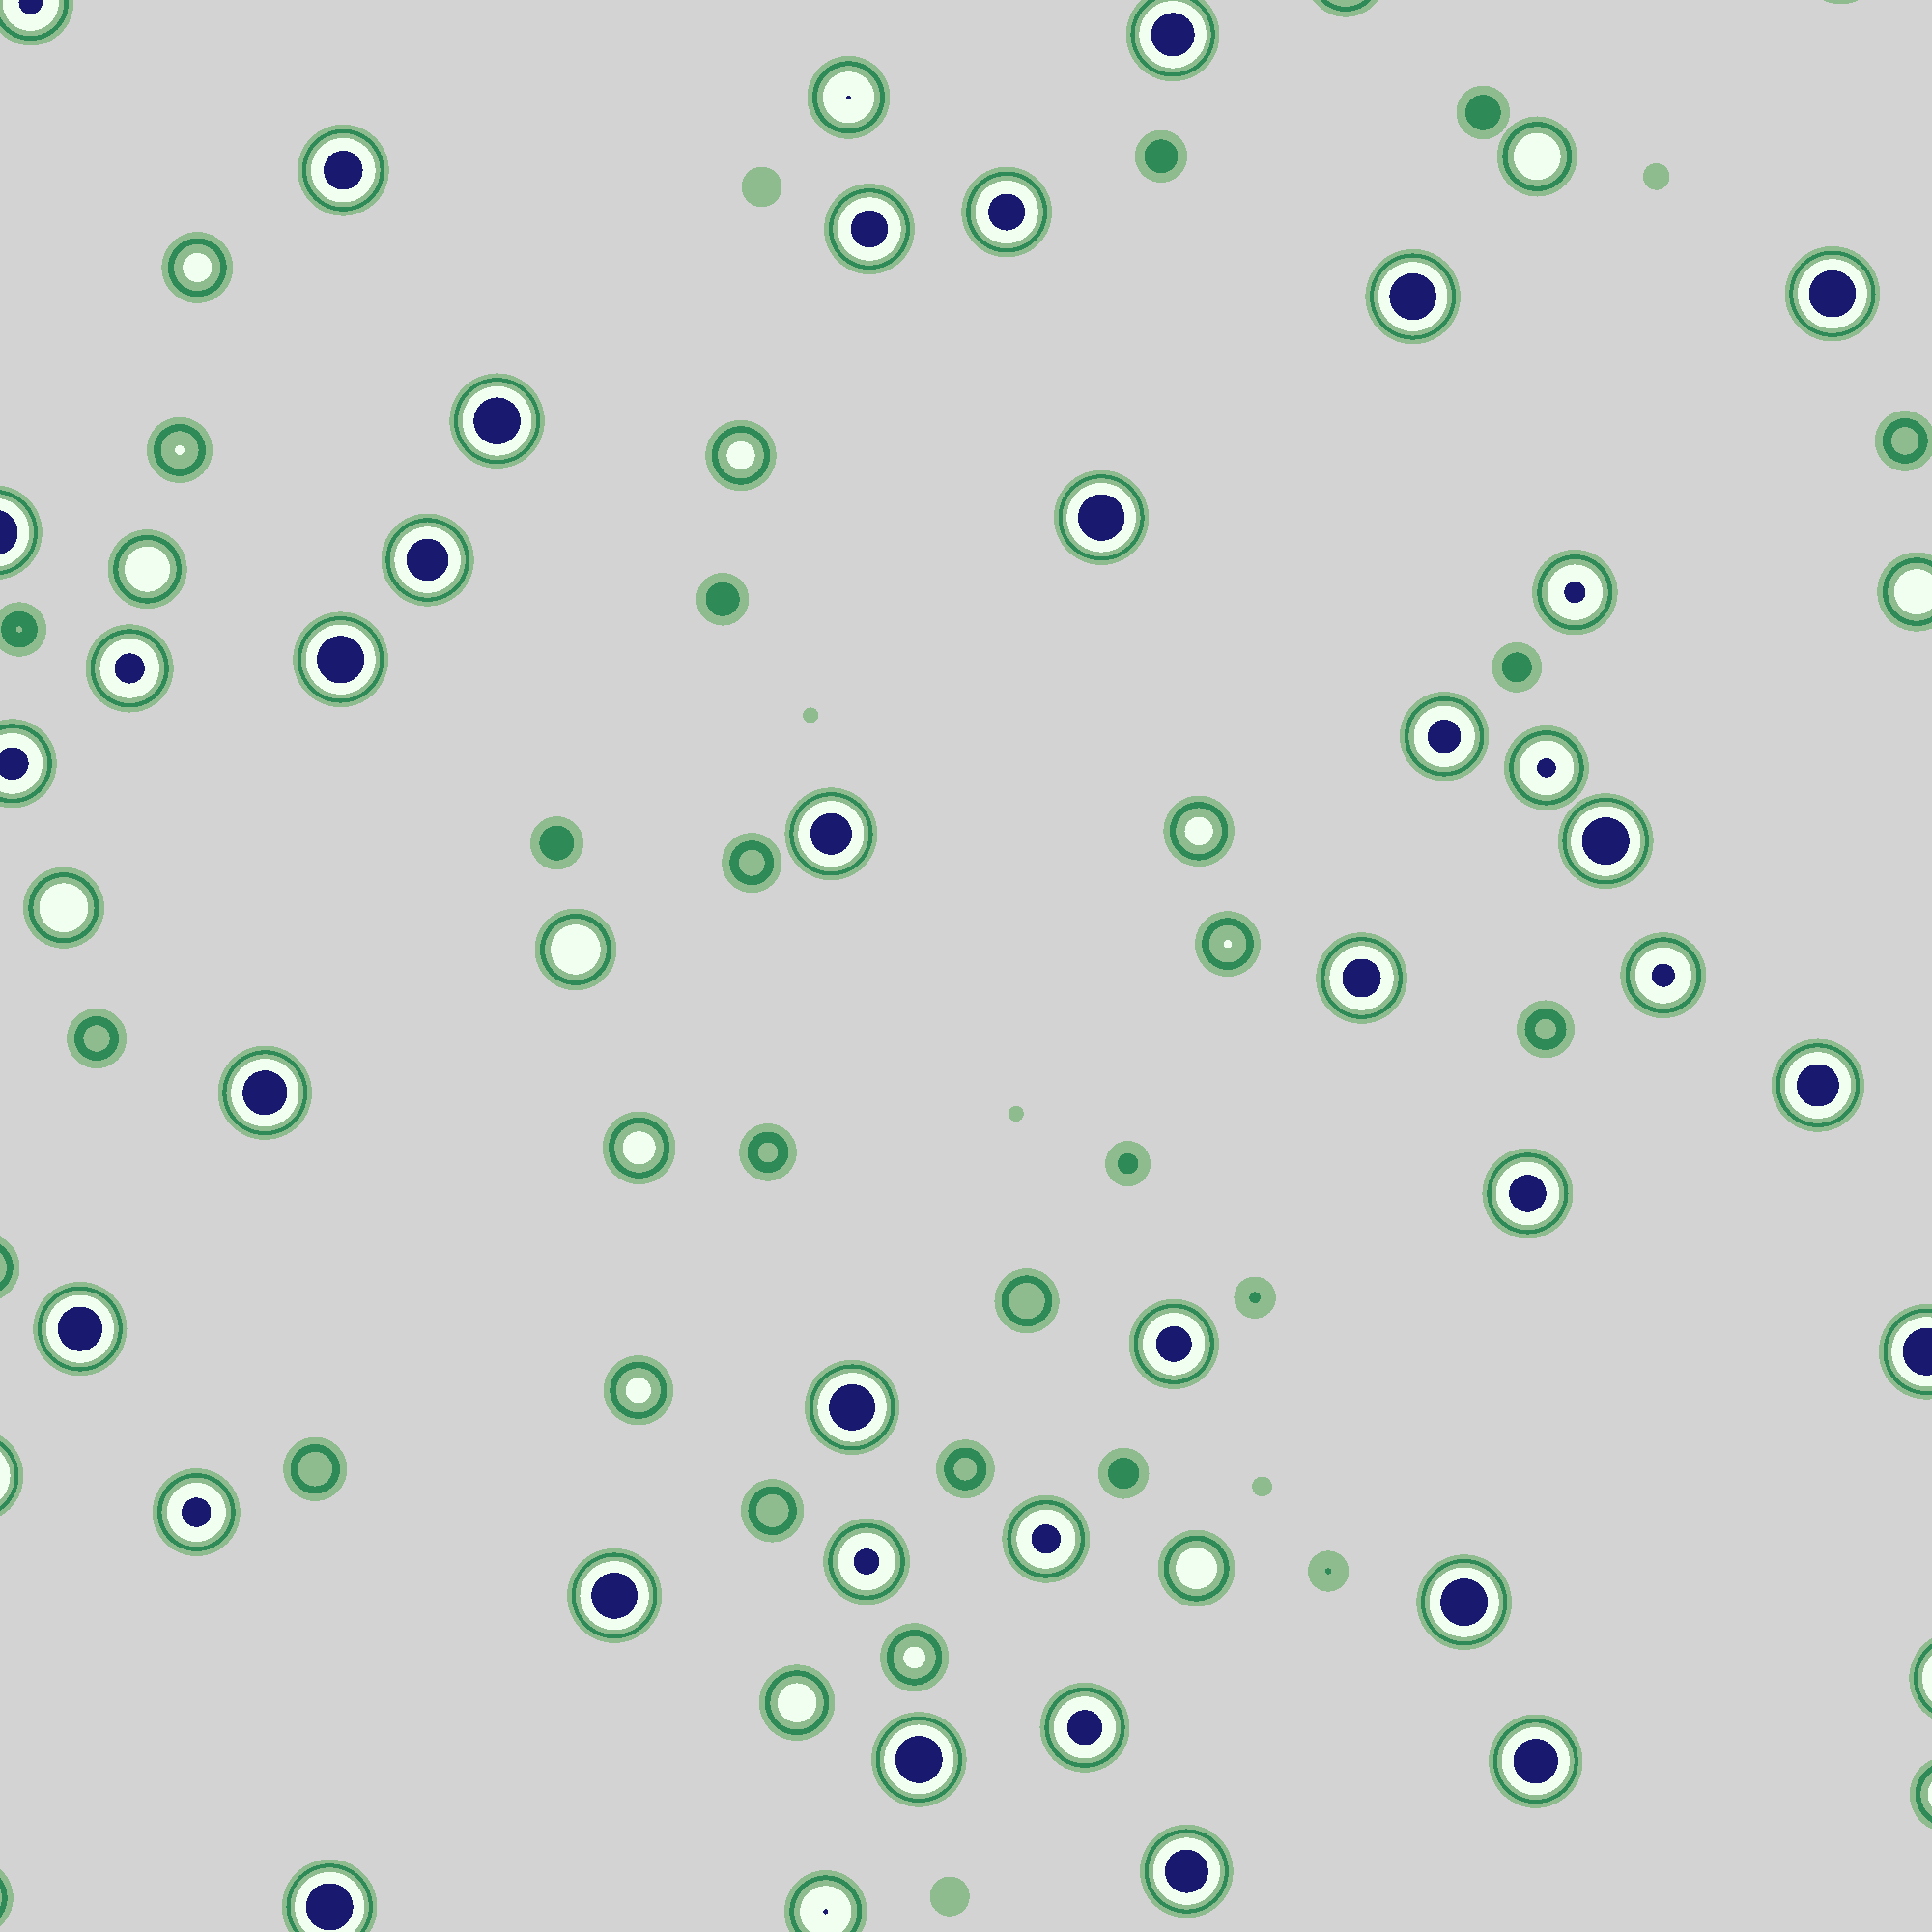

In [19]:
plot_mat_zoom = openmc.Plot.from_geometry(geometry)
plot_mat_zoom.color_by = 'material'
plot_mat_zoom.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_zoom.basis = 'xy'
plot_mat_zoom.origin = (0, 0, 0)
plot_mat_zoom.width = (0.25*bcc_l, 0.25*bcc_l)
plot_mat_zoom.pixels = (2000, 2000)
plot_mat_zoom.filename = 'mat_zoom.png'
openmc.plot_inline(plot_mat_zoom)

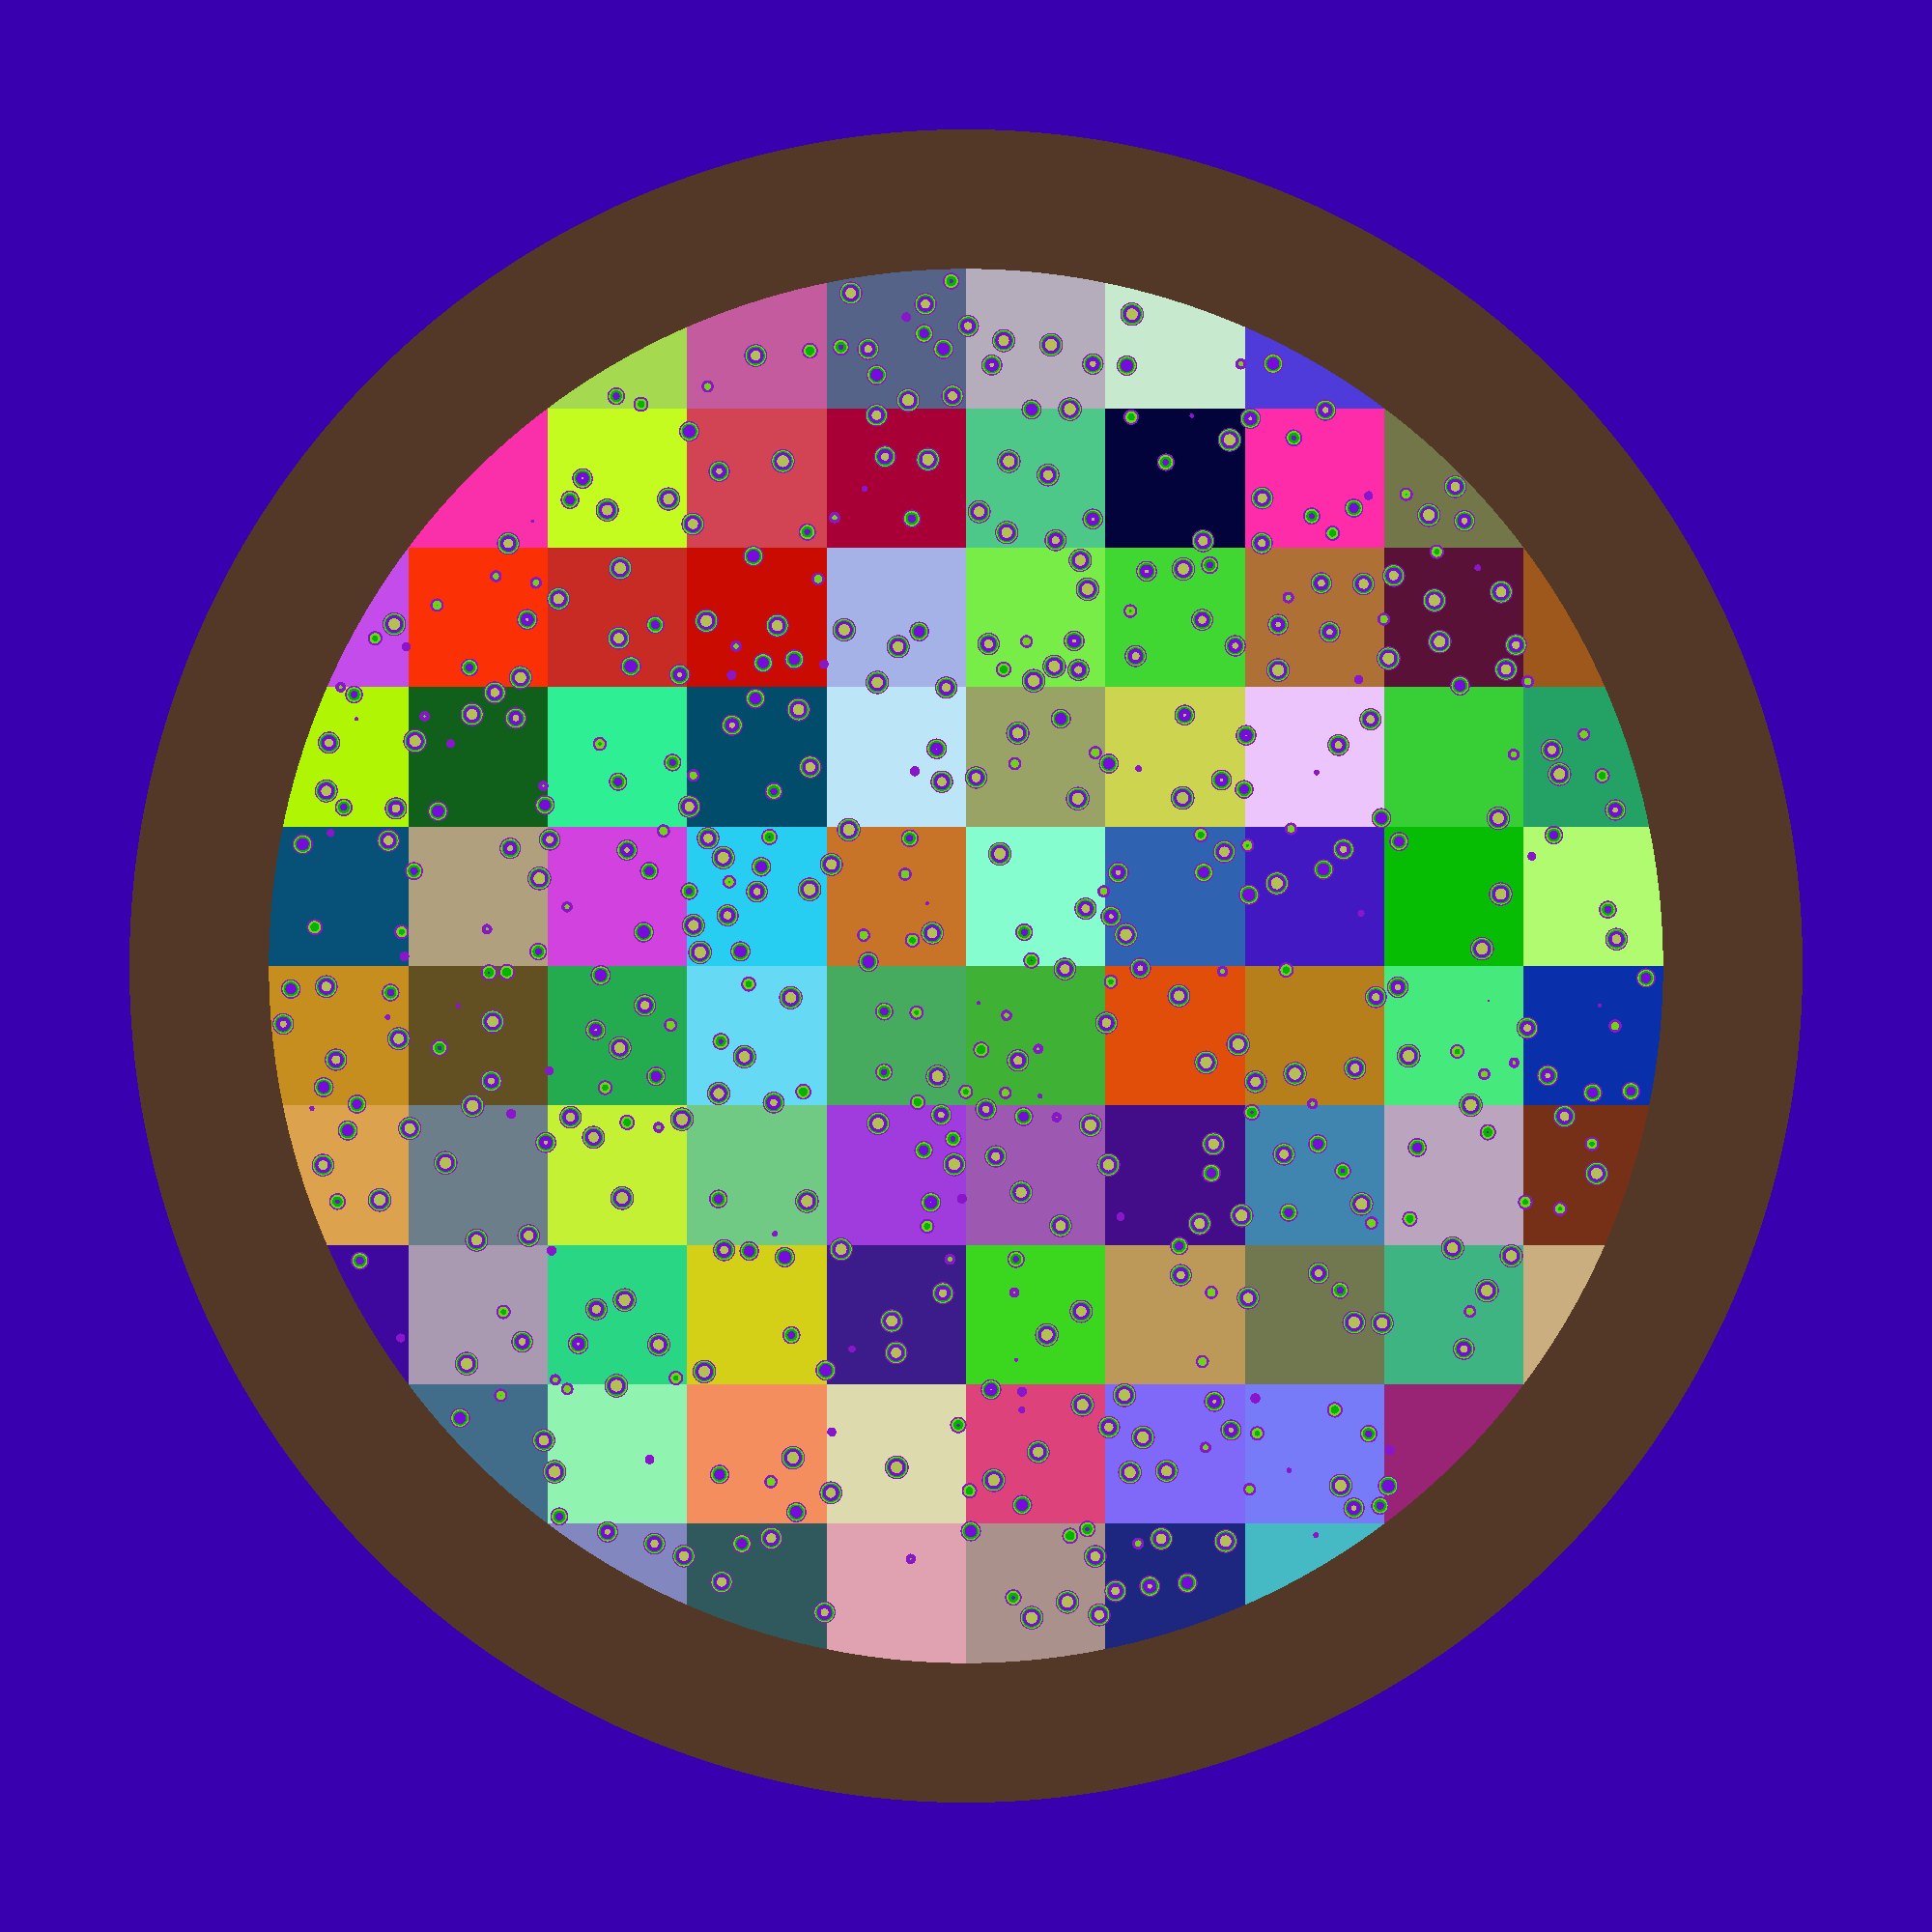

In [19]:
plot_cell_body = openmc.Plot.from_geometry(geometry)
plot_cell_body.show_overlaps = True
plot_cell_body.overlap_color = 'red'
plot_cell_body.basis = 'xy'
plot_cell_body.origin = (0, 0, 0)
plot_cell_body.width = (bcc_l, bcc_l)
plot_cell_body.pixels = (2000, 2000)
plot_cell_body.filename = 'cell_body.png'
openmc.plot_inline(plot_cell_body)

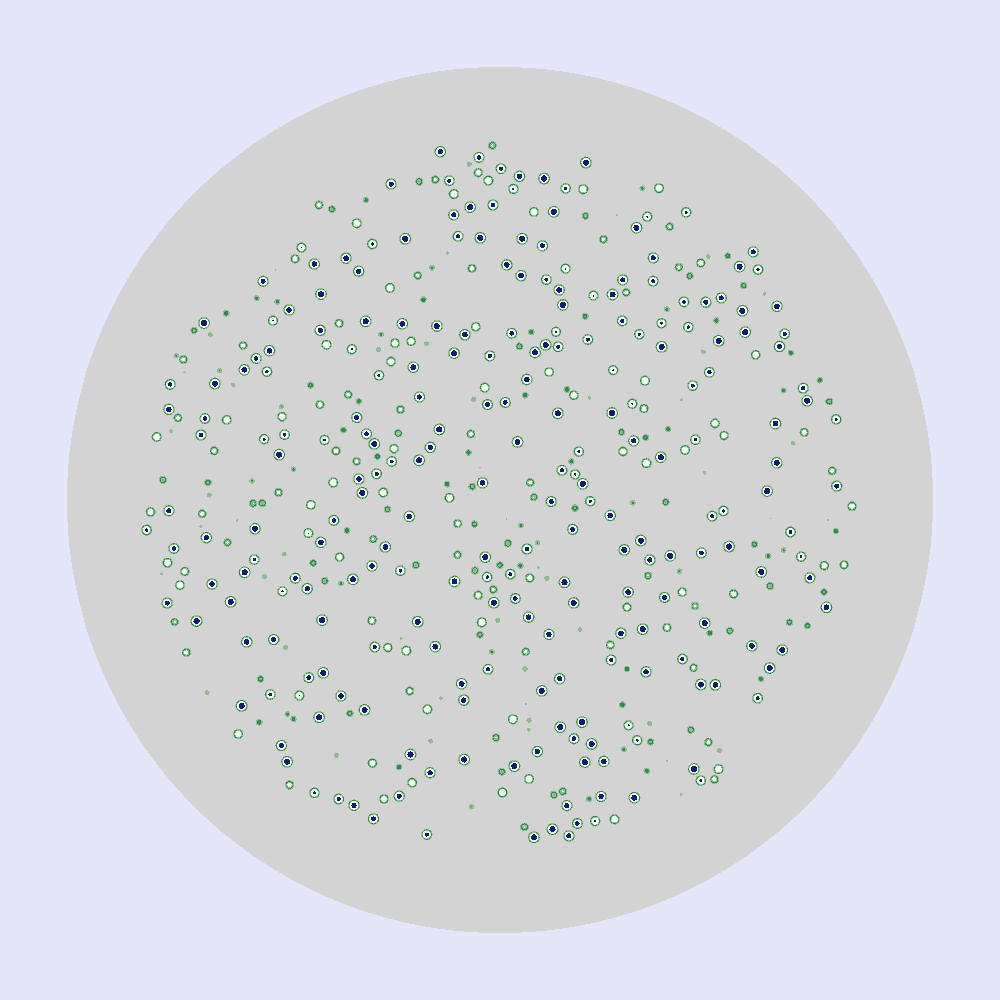

In [20]:
plot_mat_body = openmc.Plot.from_geometry(geometry)
plot_mat_body.color_by = 'material'
plot_mat_body.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_body.basis = 'xy'
plot_mat_body.origin = (0, 0, 0)
plot_mat_body.width = (bcc_l, bcc_l)
plot_mat_body.pixels = (1000, 1000)
plot_mat_body.filename = 'mat_body.png'
openmc.plot_inline(plot_mat_body)

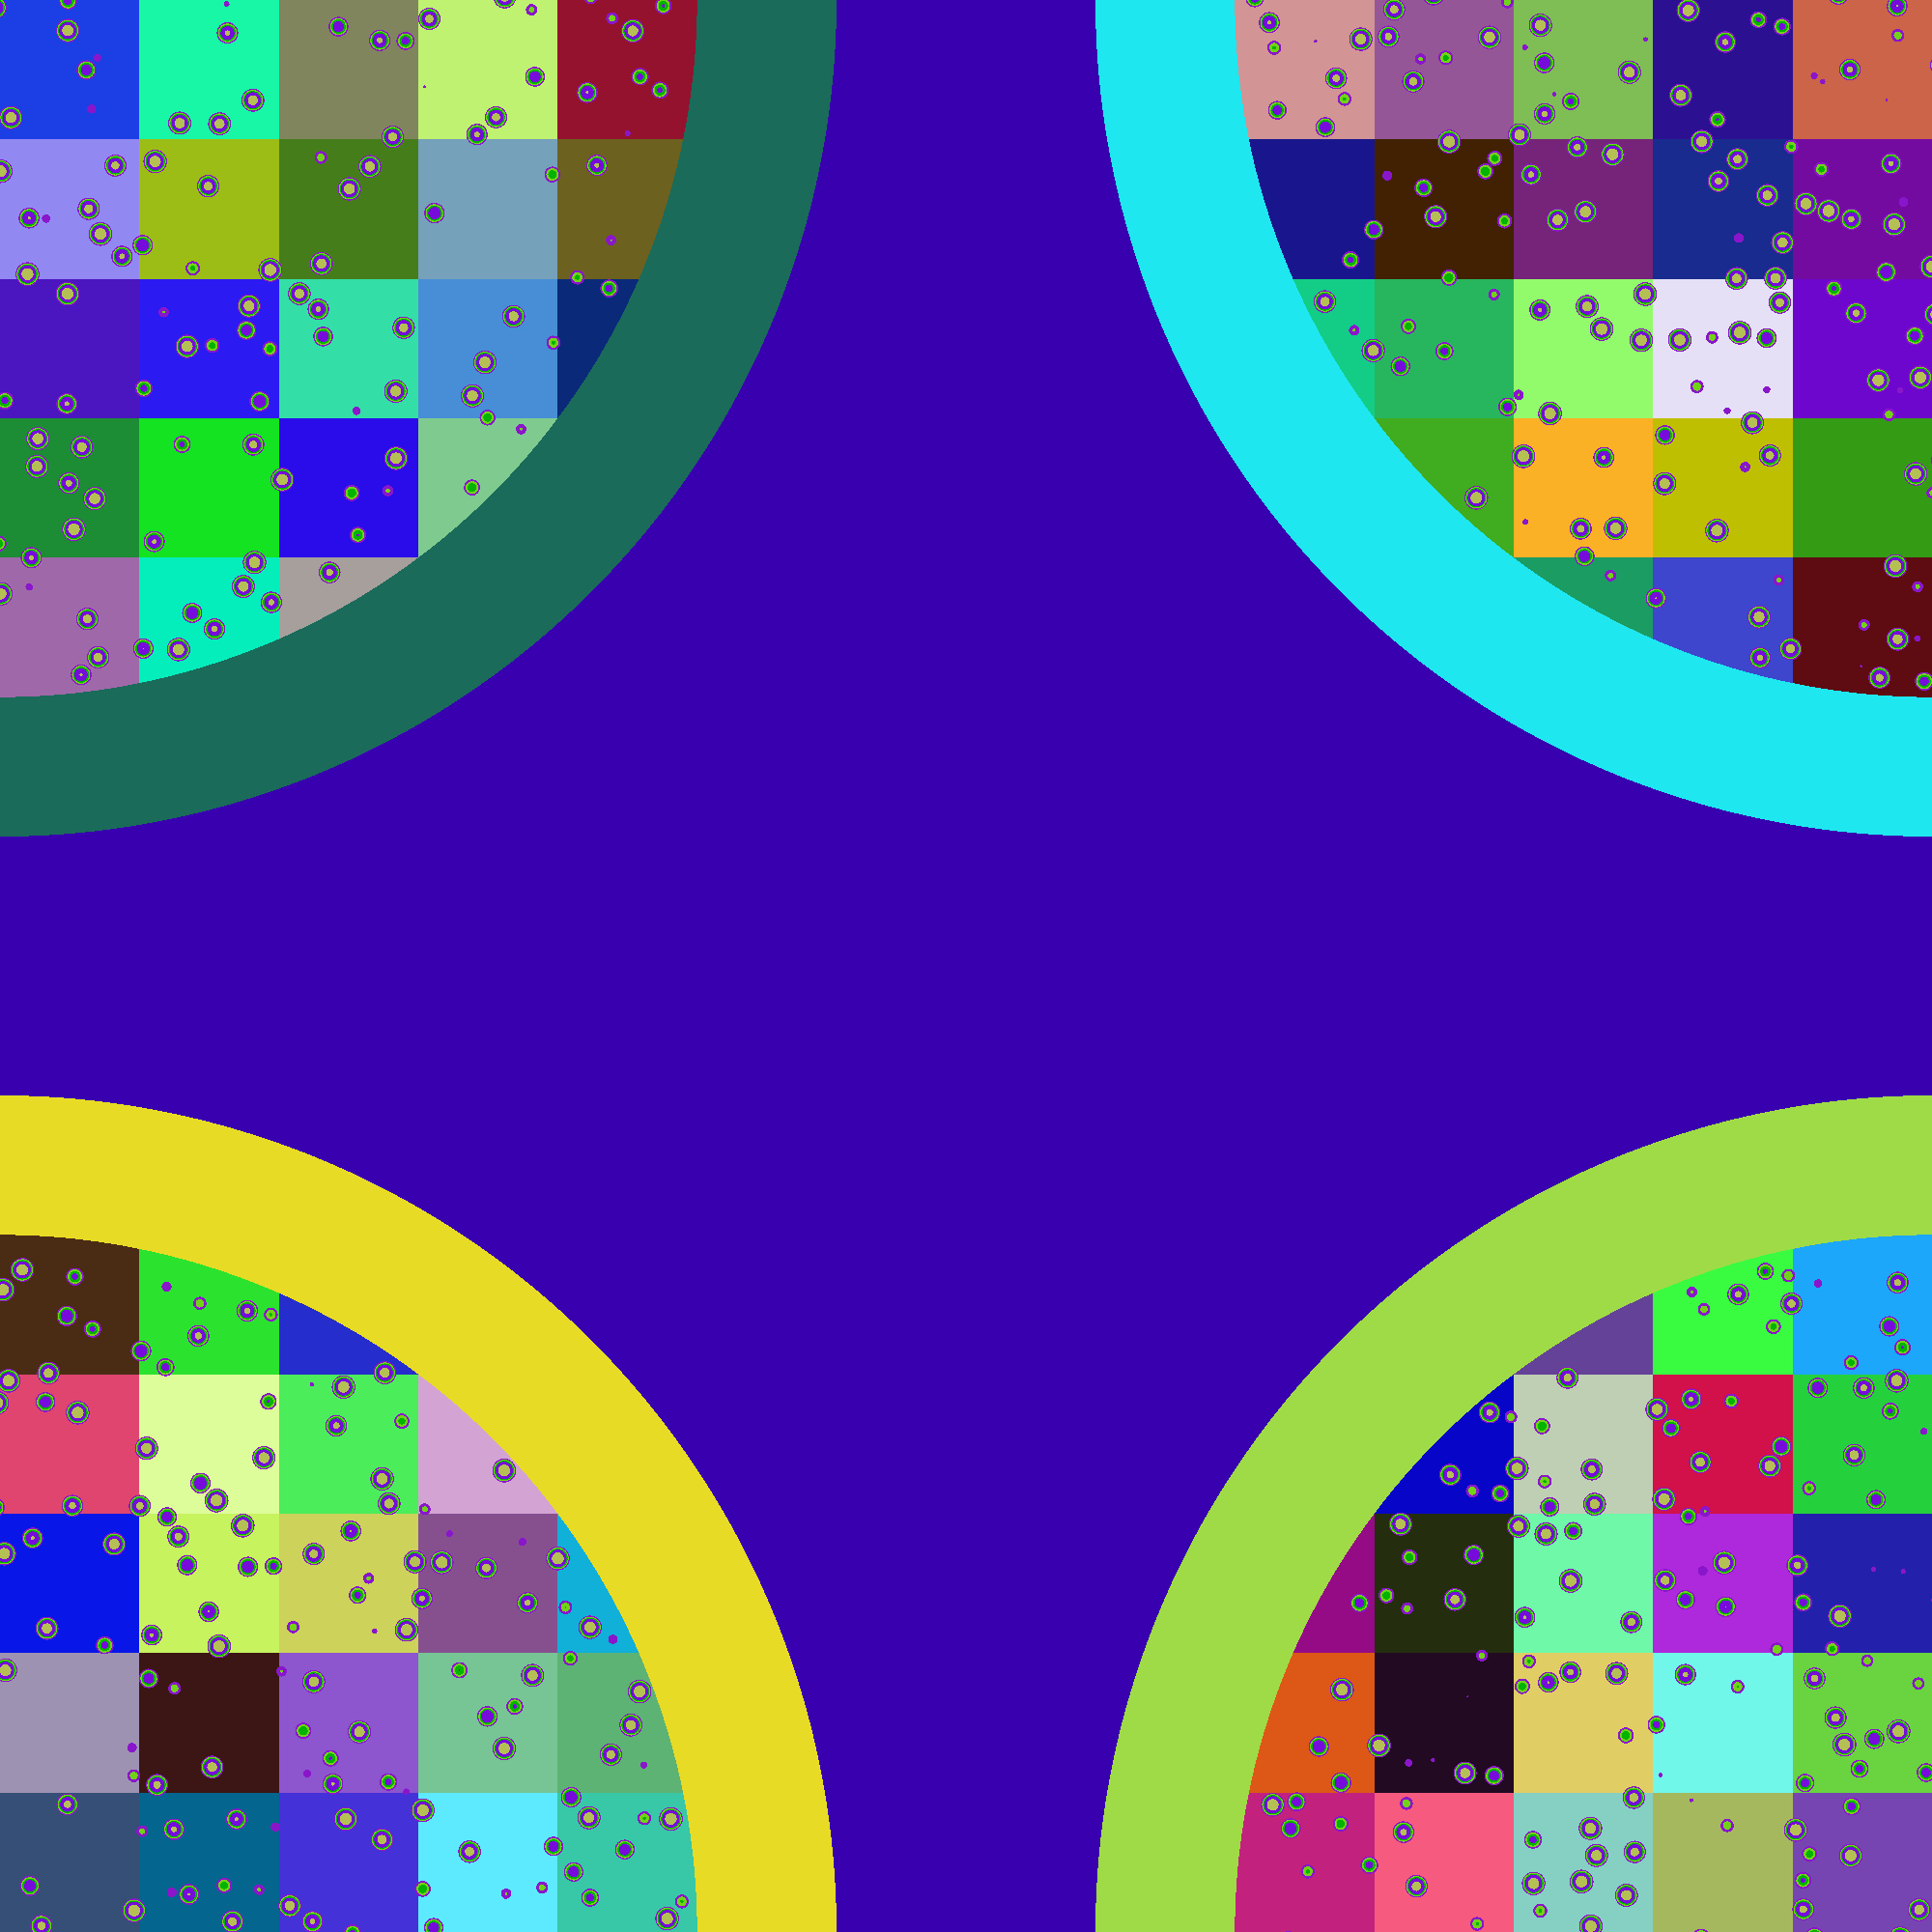

In [21]:
plot_cell_p1 = openmc.Plot.from_geometry(geometry)
plot_cell_p1.show_overlaps = True
plot_cell_p1.overlap_color = 'red'
plot_cell_p1.basis = 'xy'
plot_cell_p1.origin = (0, 0, -0.4999*bcc_l)
plot_cell_p1.width = (bcc_l, bcc_l)
plot_cell_p1.pixels = (2000, 2000)
plot_cell_p1.filename = 'cell_0_0_-1.png'
openmc.plot_inline(plot_cell_p1)

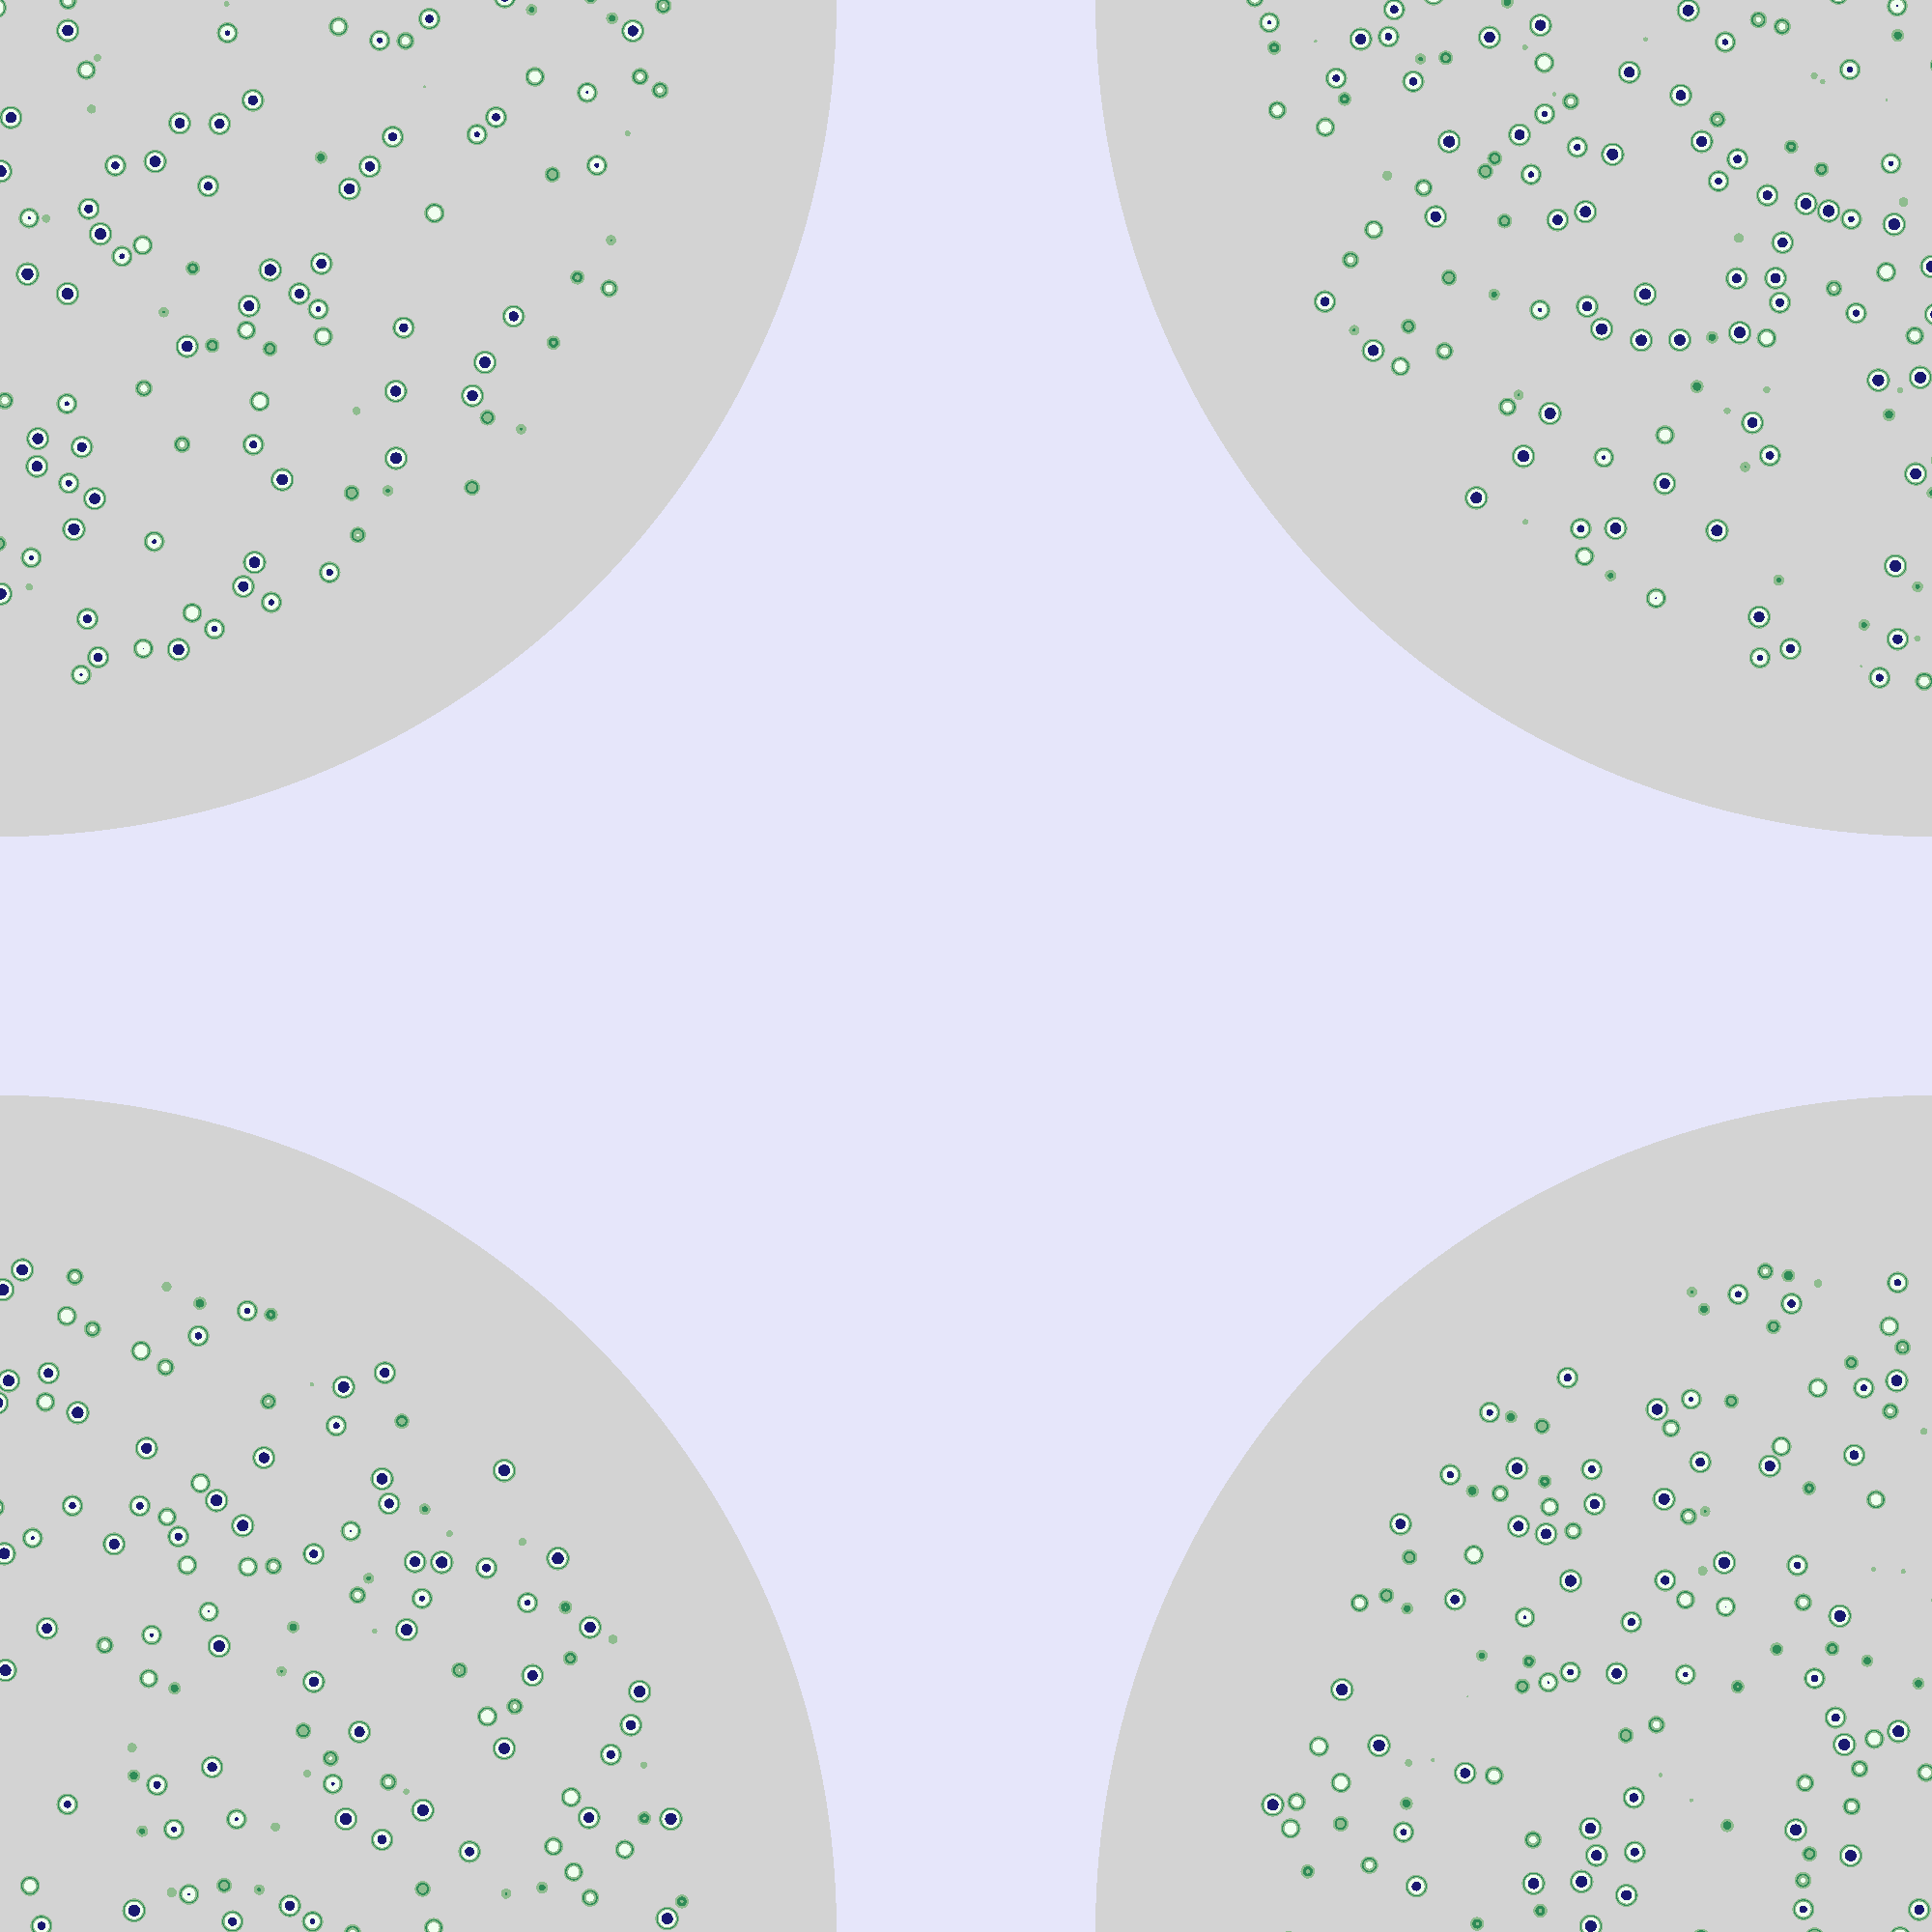

In [22]:
plot_mat_p1 = openmc.Plot.from_geometry(geometry)
plot_mat_p1.color_by = 'material'
plot_mat_p1.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_p1.basis = 'xy'
plot_mat_p1.origin = (0, 0, -0.4999*bcc_l)
plot_mat_p1.width = (bcc_l, bcc_l)
plot_mat_p1.pixels = (2000, 2000)
plot_mat_p1.filename = 'mat_0_0_-1.png'
openmc.plot_inline(plot_mat_p1)

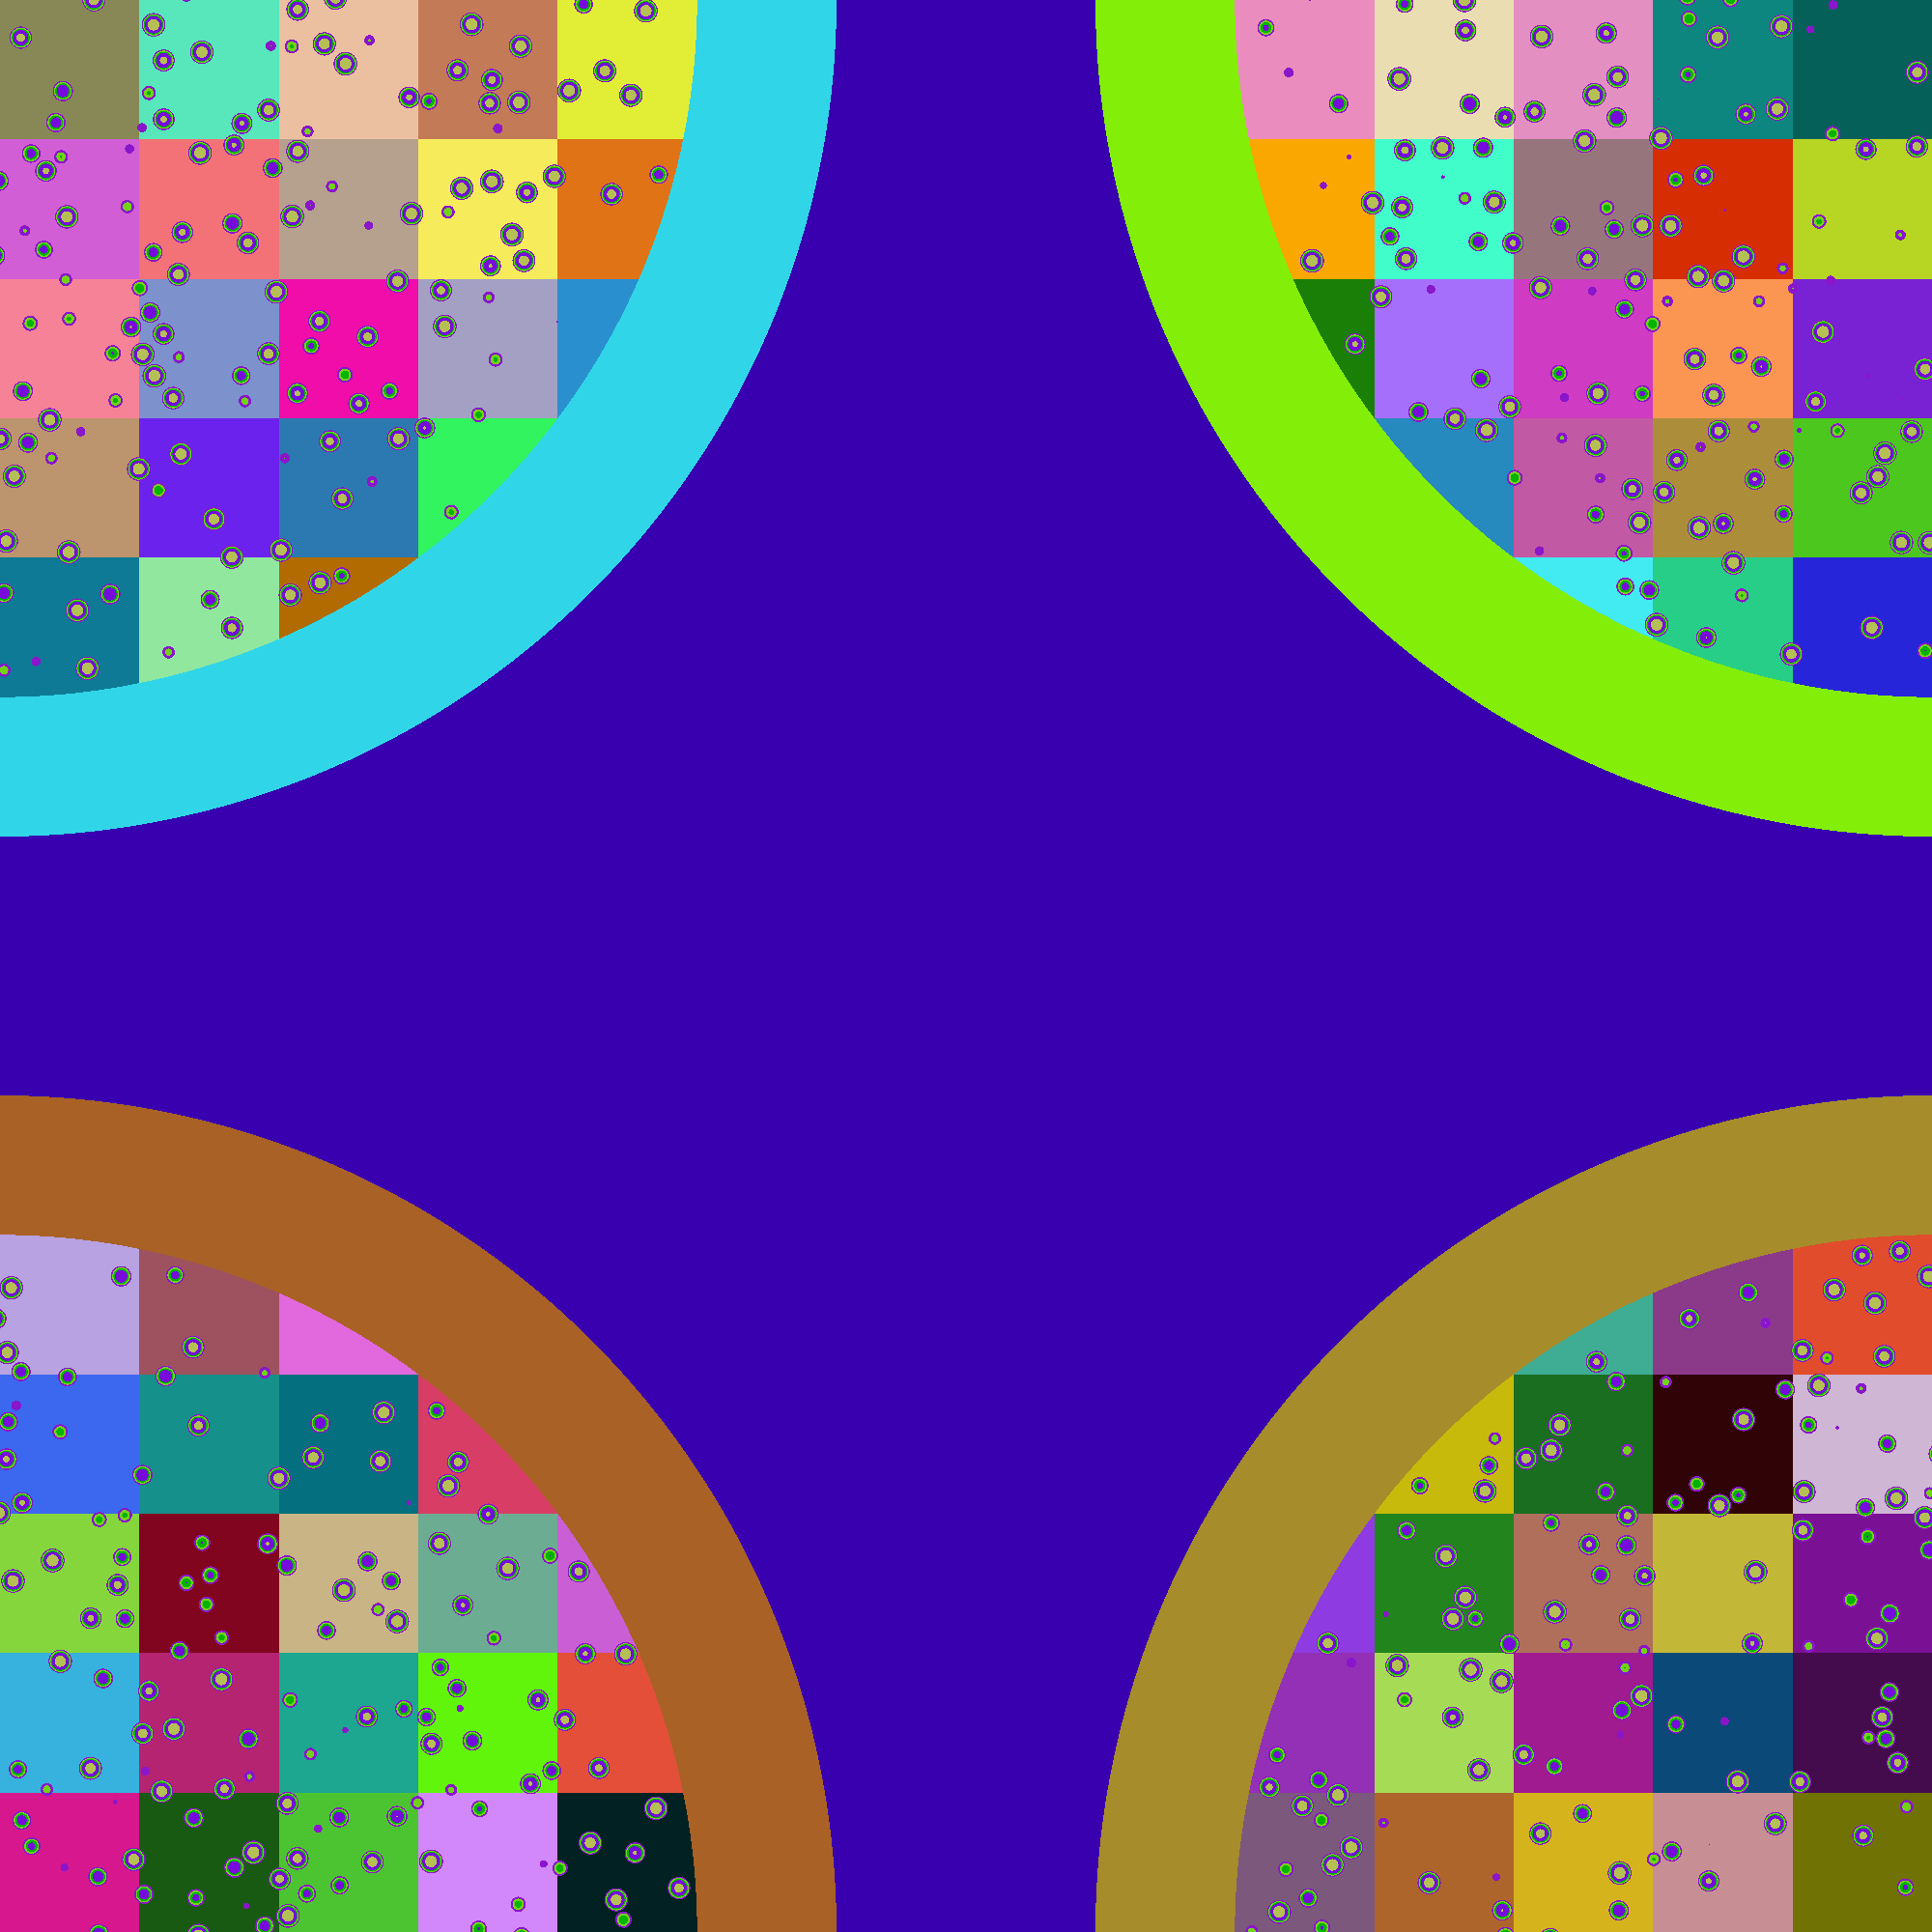

In [23]:
plot_cell_p2 = openmc.Plot.from_geometry(geometry)
plot_cell_p2.show_overlaps = True
plot_cell_p2.overlap_color = 'red'
plot_cell_p2.basis = 'xy'
plot_cell_p2.origin = (0, 0, 0.4999*bcc_l)
plot_cell_p2.width = (bcc_l, bcc_l)
plot_cell_p2.pixels = (2000, 2000)
plot_cell_p2.filename = 'cell_0_0_1.png'
openmc.plot_inline(plot_cell_p2)

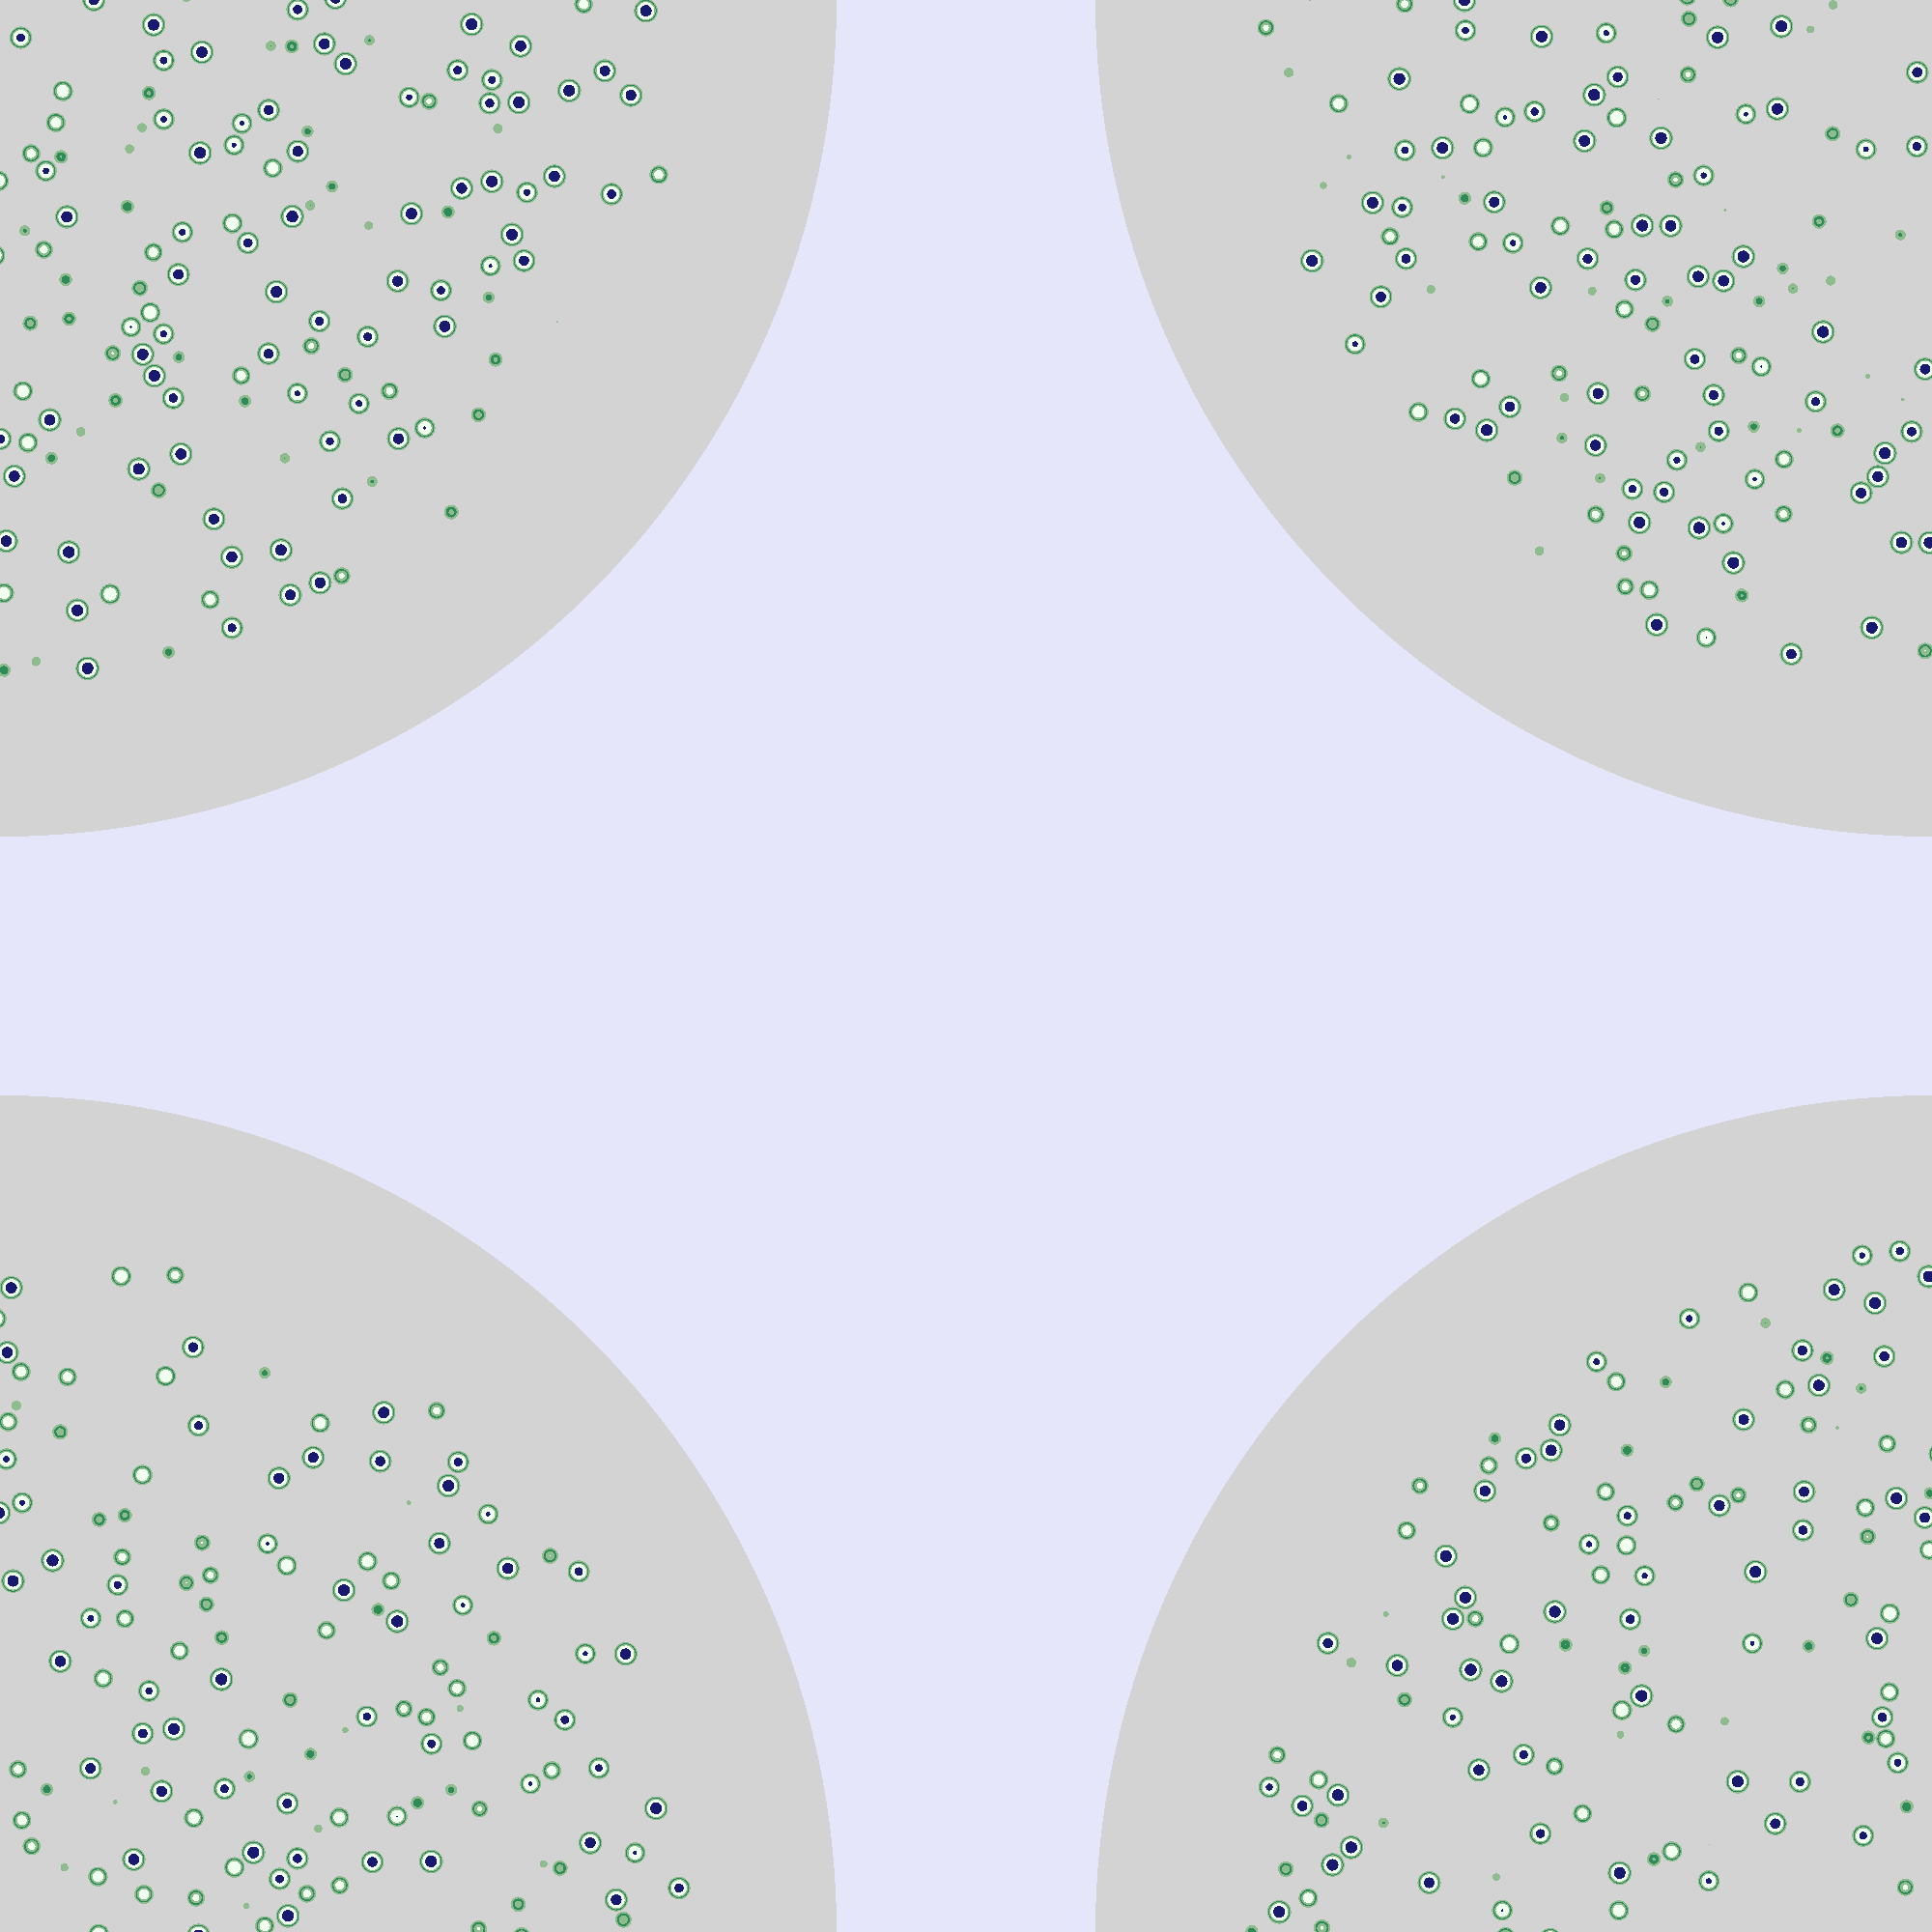

In [24]:
plot_mat_p2 = openmc.Plot.from_geometry(geometry)
plot_mat_p2.color_by = 'material'
plot_mat_p2.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_p2.basis = 'xy'
plot_mat_p2.origin = (0, 0, 0.4999*bcc_l)
plot_mat_p2.width = (bcc_l, bcc_l)
plot_mat_p2.pixels = (2000, 2000)
plot_mat_p2.filename = 'mat_0_0_1.png'
openmc.plot_inline(plot_mat_p2)

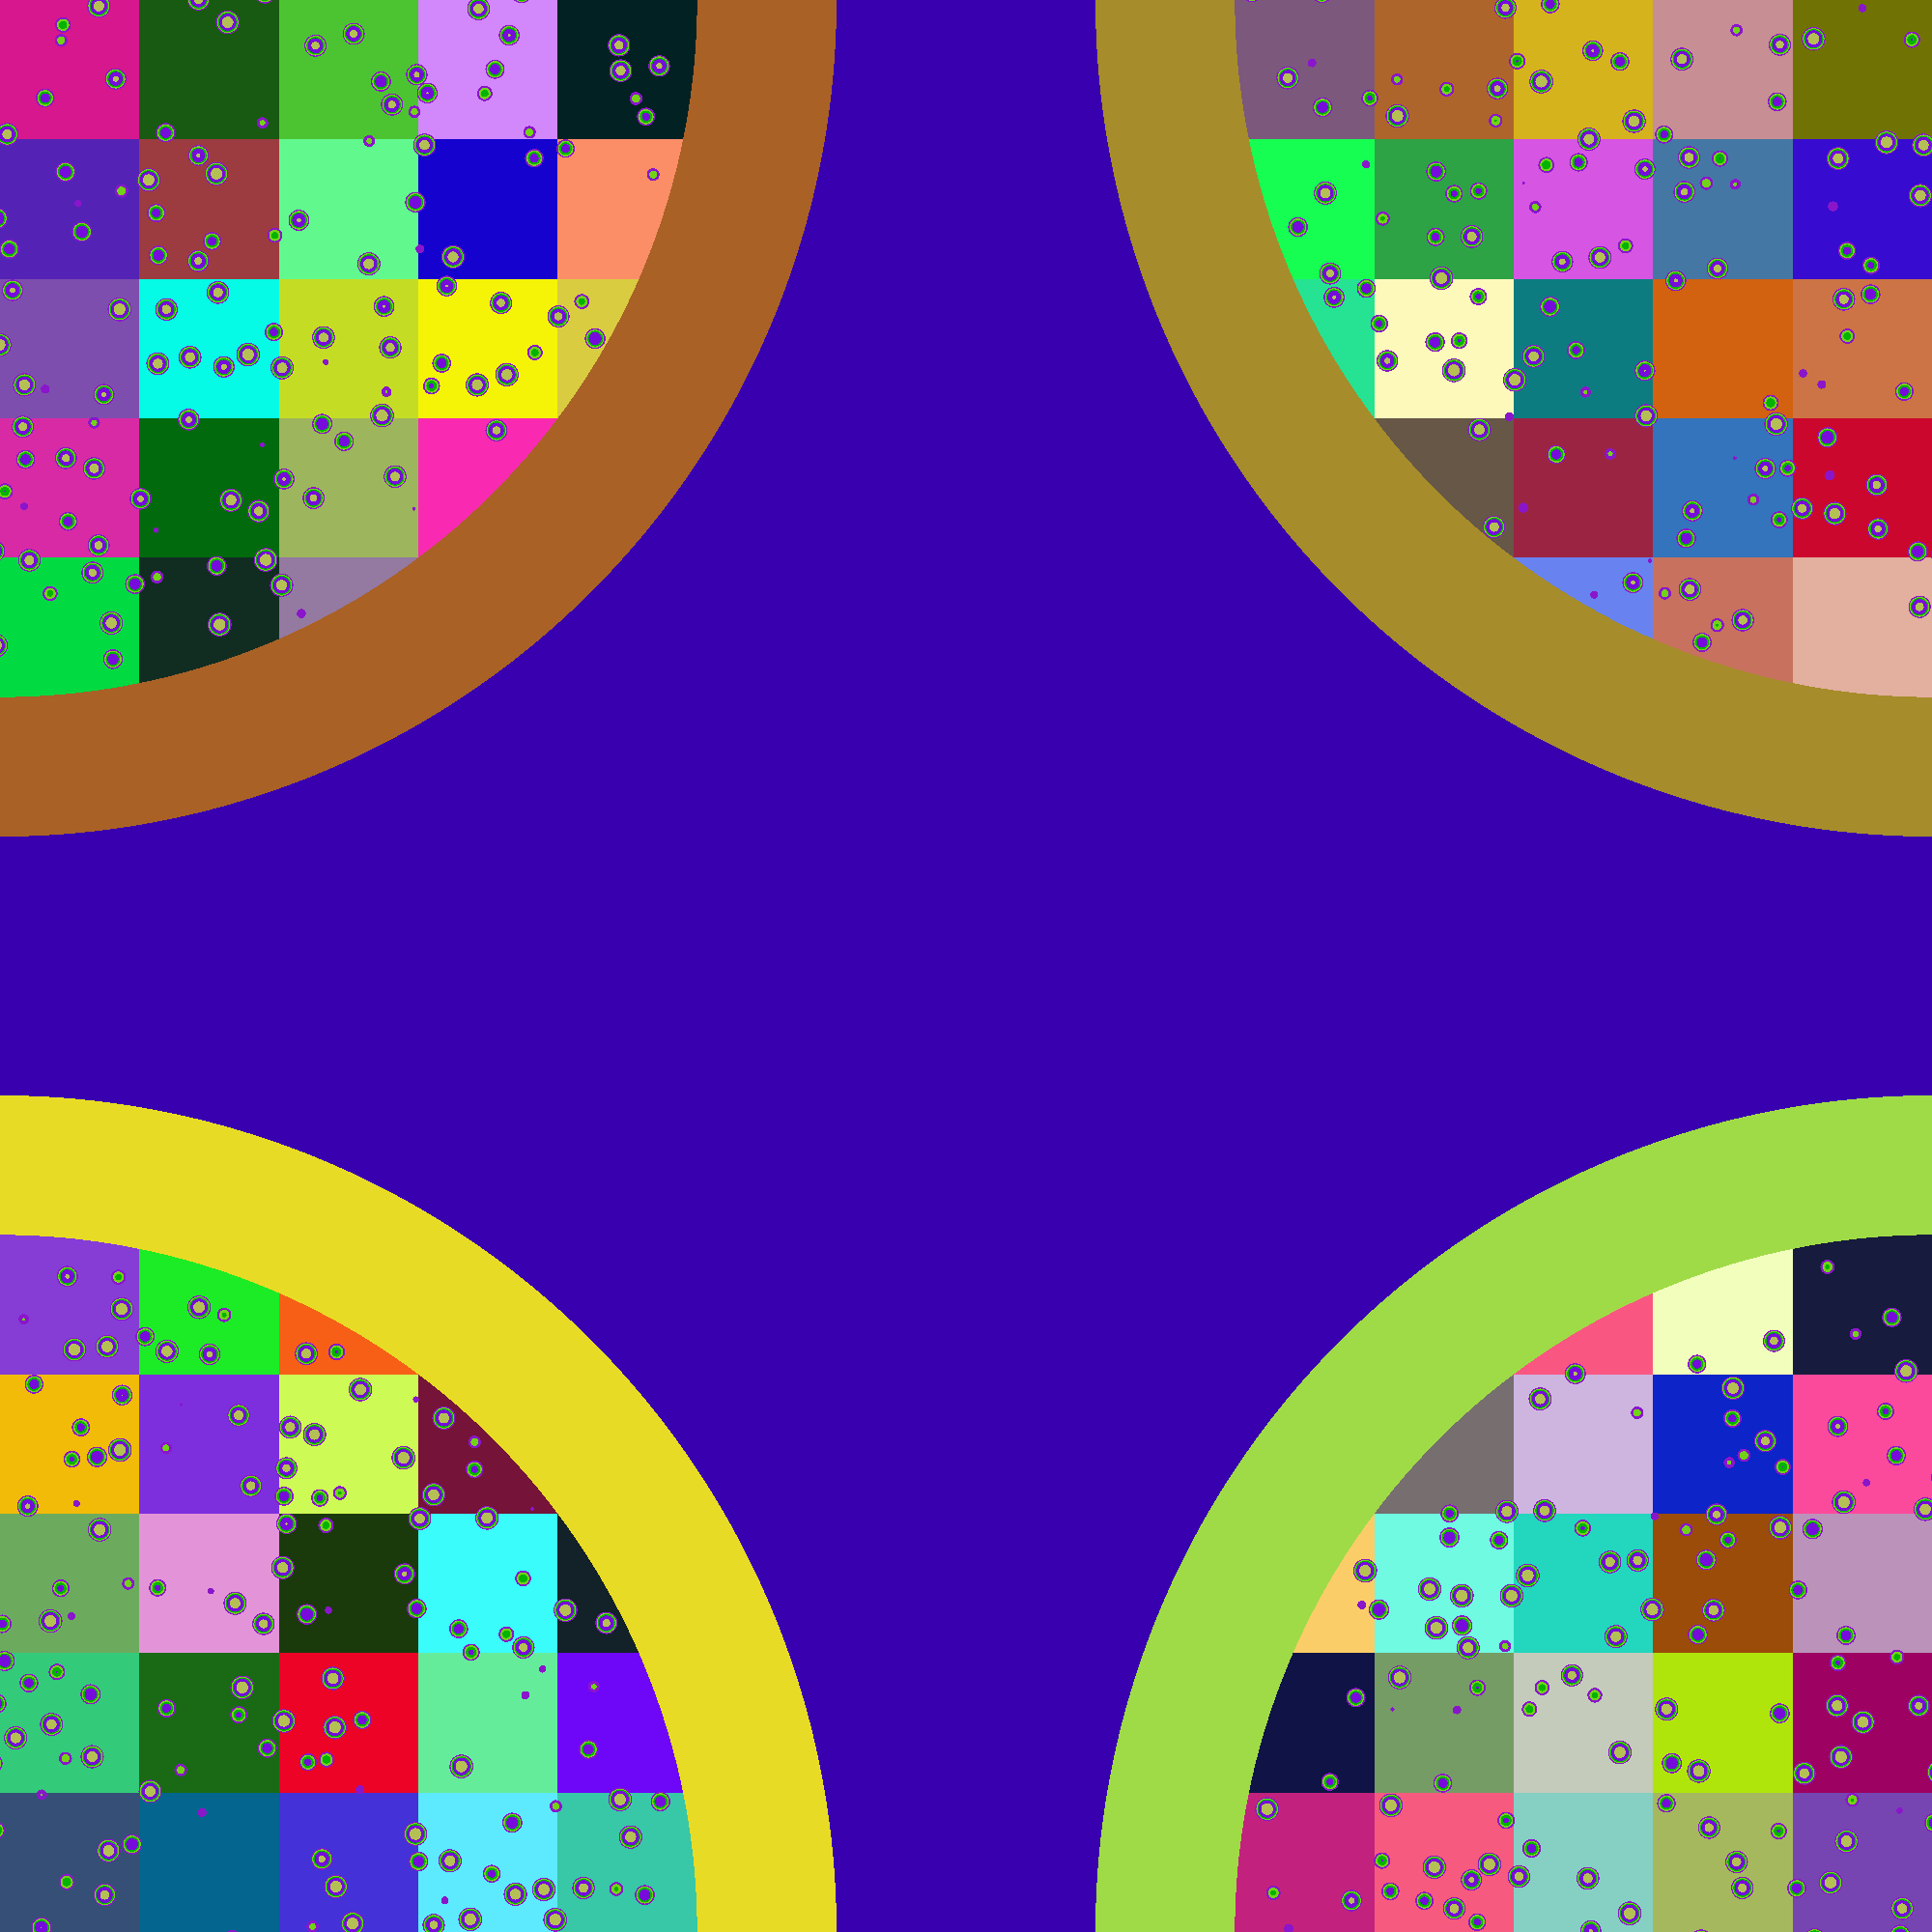

In [25]:
plot_cell_p3 = openmc.Plot.from_geometry(geometry)
plot_cell_p3.show_overlaps = True
plot_cell_p3.overlap_color = 'red'
plot_cell_p3.basis = 'xz'
plot_cell_p3.origin = (0, -0.4999*bcc_l, 0)
plot_cell_p3.width = (bcc_l, bcc_l)
plot_cell_p3.pixels = (2000, 2000)
plot_cell_p3.filename = 'cell_0_-1_0.png'
openmc.plot_inline(plot_cell_p3)

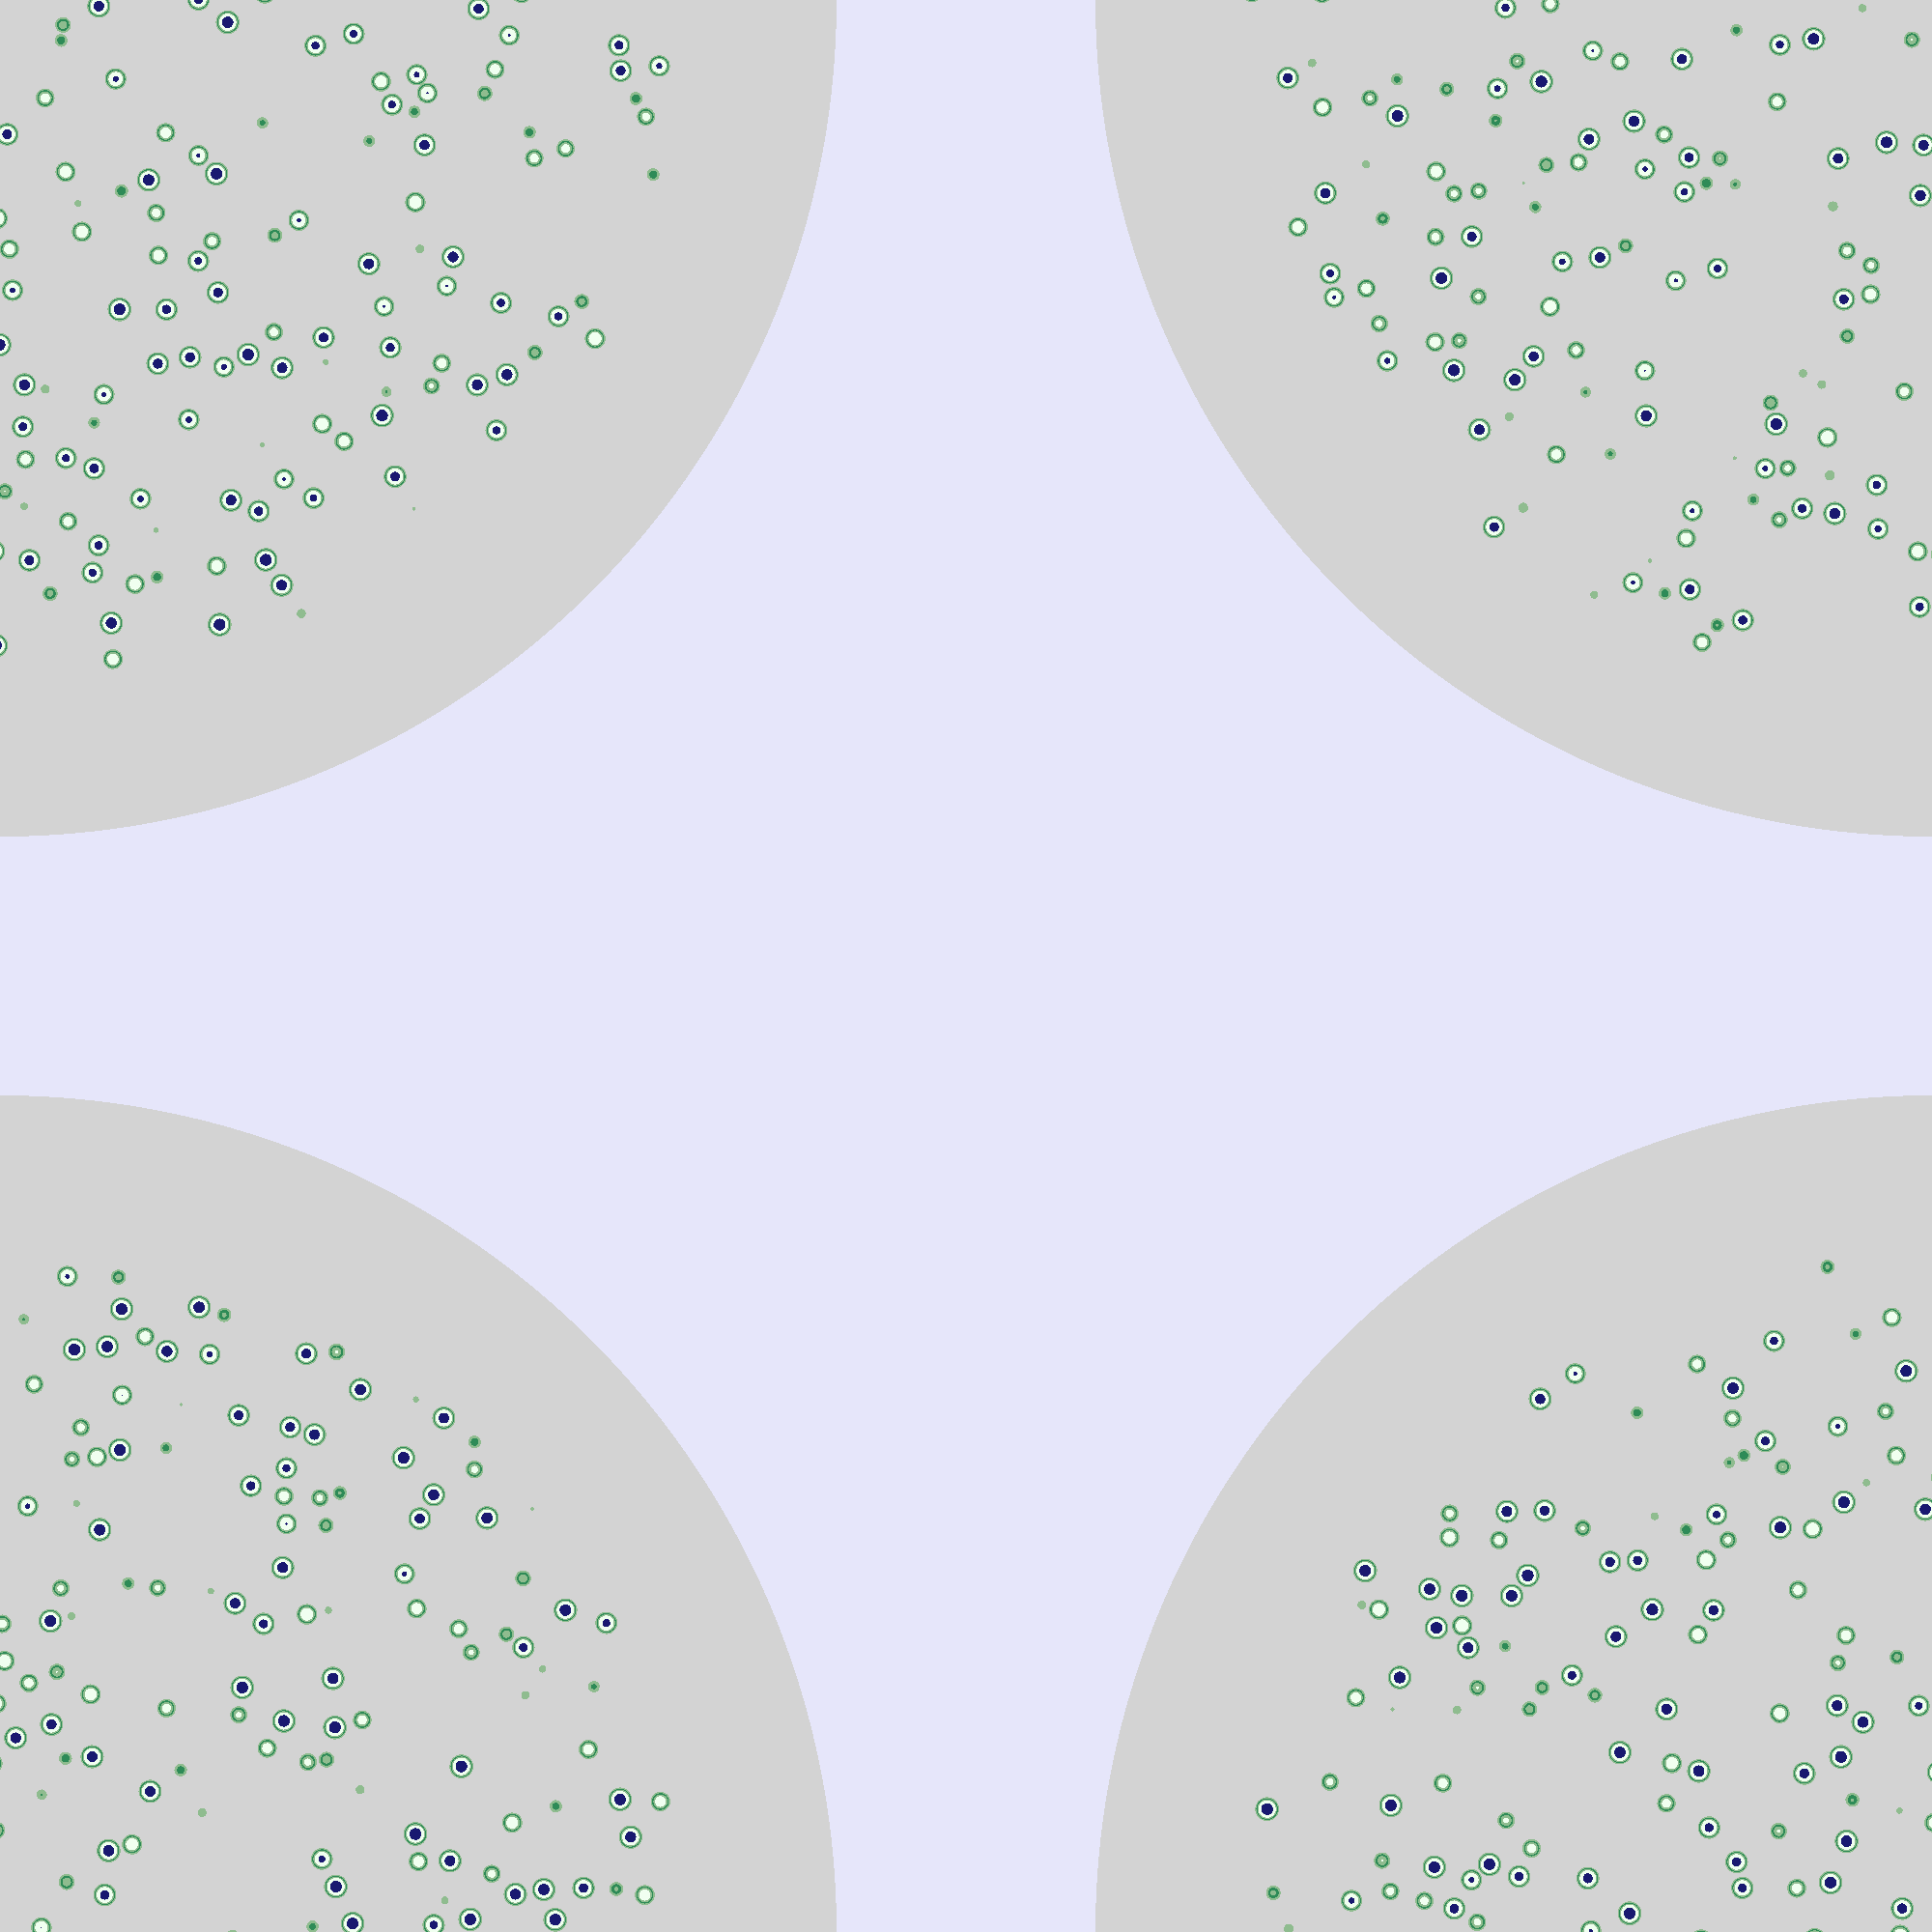

In [26]:
plot_mat_p3 = openmc.Plot.from_geometry(geometry)
plot_mat_p3.color_by = 'material'
plot_mat_p3.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_p3.basis = 'xz'
plot_mat_p3.origin = (0, -0.4999*bcc_l, 0)
plot_mat_p3.width = (bcc_l, bcc_l)
plot_mat_p3.pixels = (2000, 2000)
plot_mat_p3.filename = 'mat_0_-1_0.png'
openmc.plot_inline(plot_mat_p3)

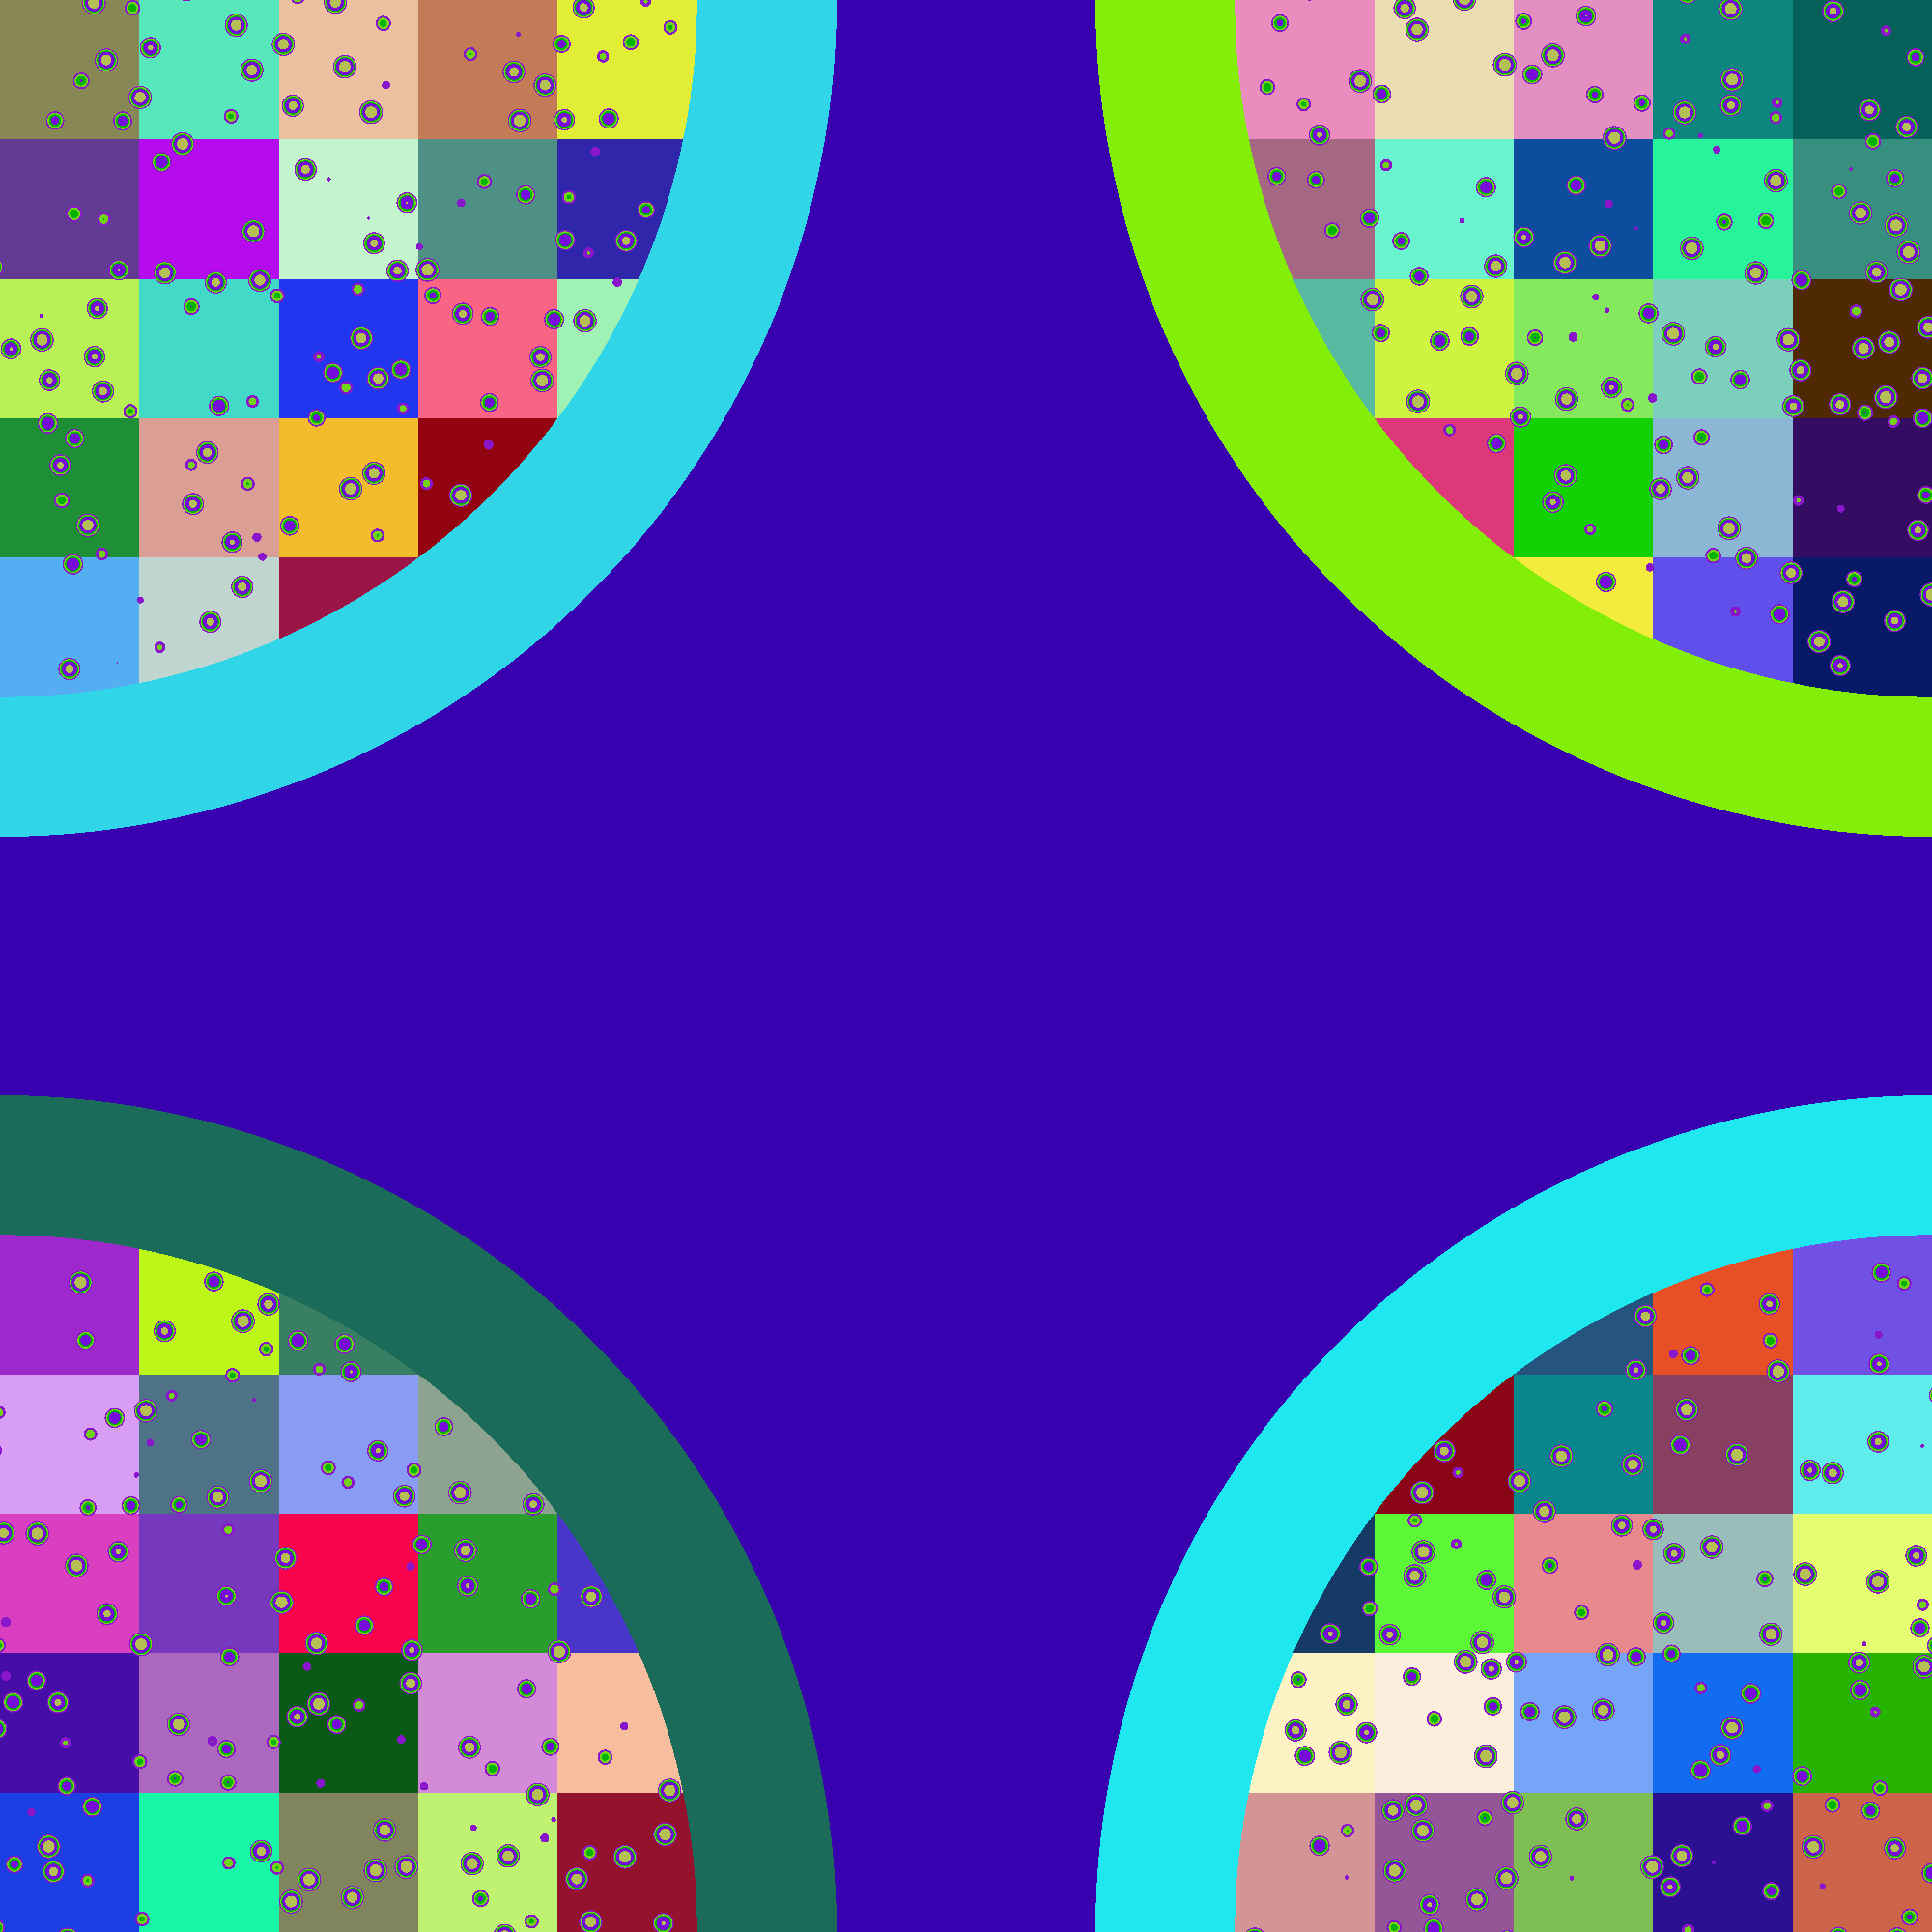

In [27]:
plot_cell_p4 = openmc.Plot.from_geometry(geometry)
plot_cell_p4.show_overlaps = True
plot_cell_p4.overlap_color = 'red'
plot_cell_p4.basis = 'xz'
plot_cell_p4.origin = (0, 0.4999*bcc_l, 0)
plot_cell_p4.width = (bcc_l, bcc_l)
plot_cell_p4.pixels = (2000, 2000)
plot_cell_p4.filename = 'cell_0_1_0.png'
openmc.plot_inline(plot_cell_p4)

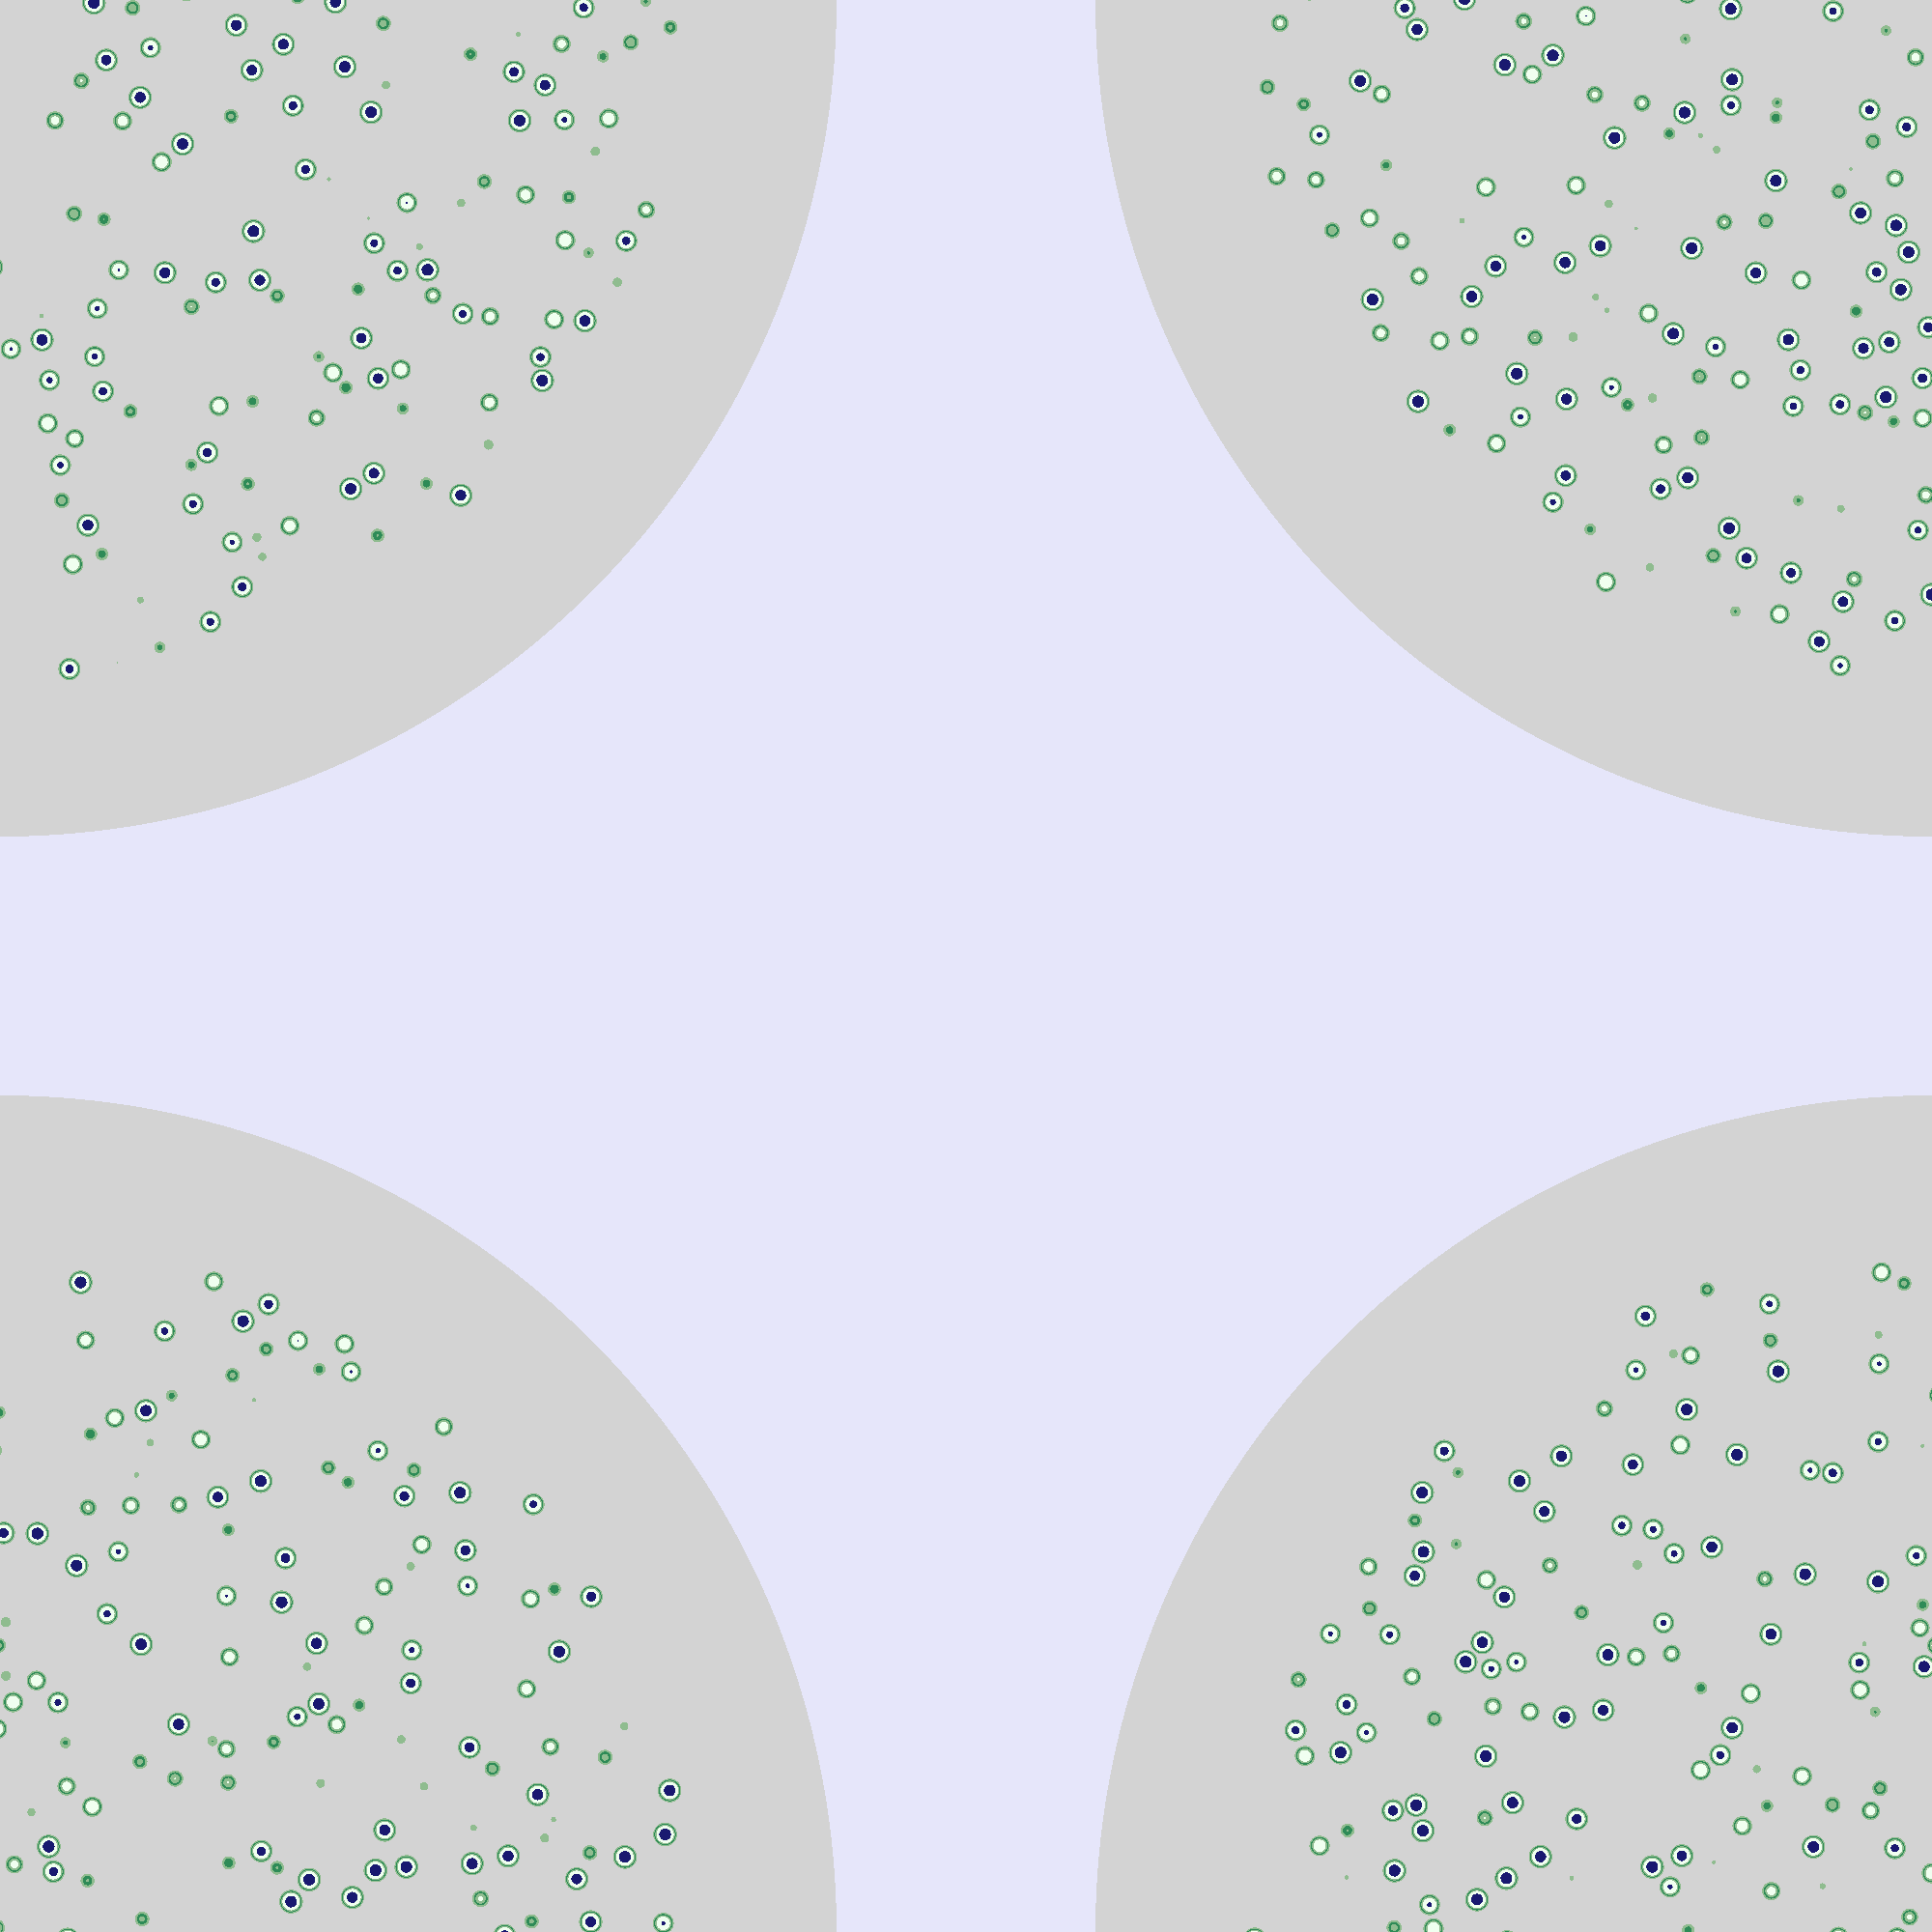

In [28]:
plot_mat_p4 = openmc.Plot.from_geometry(geometry)
plot_mat_p4.color_by = 'material'
plot_mat_p4.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_p4.basis = 'xz'
plot_mat_p4.origin = (0, 0.4999*bcc_l, 0)
plot_mat_p4.width = (bcc_l, bcc_l)
plot_mat_p4.pixels = (2000, 2000)
plot_mat_p4.filename = 'mat_0_1_0.png'
openmc.plot_inline(plot_mat_p4)

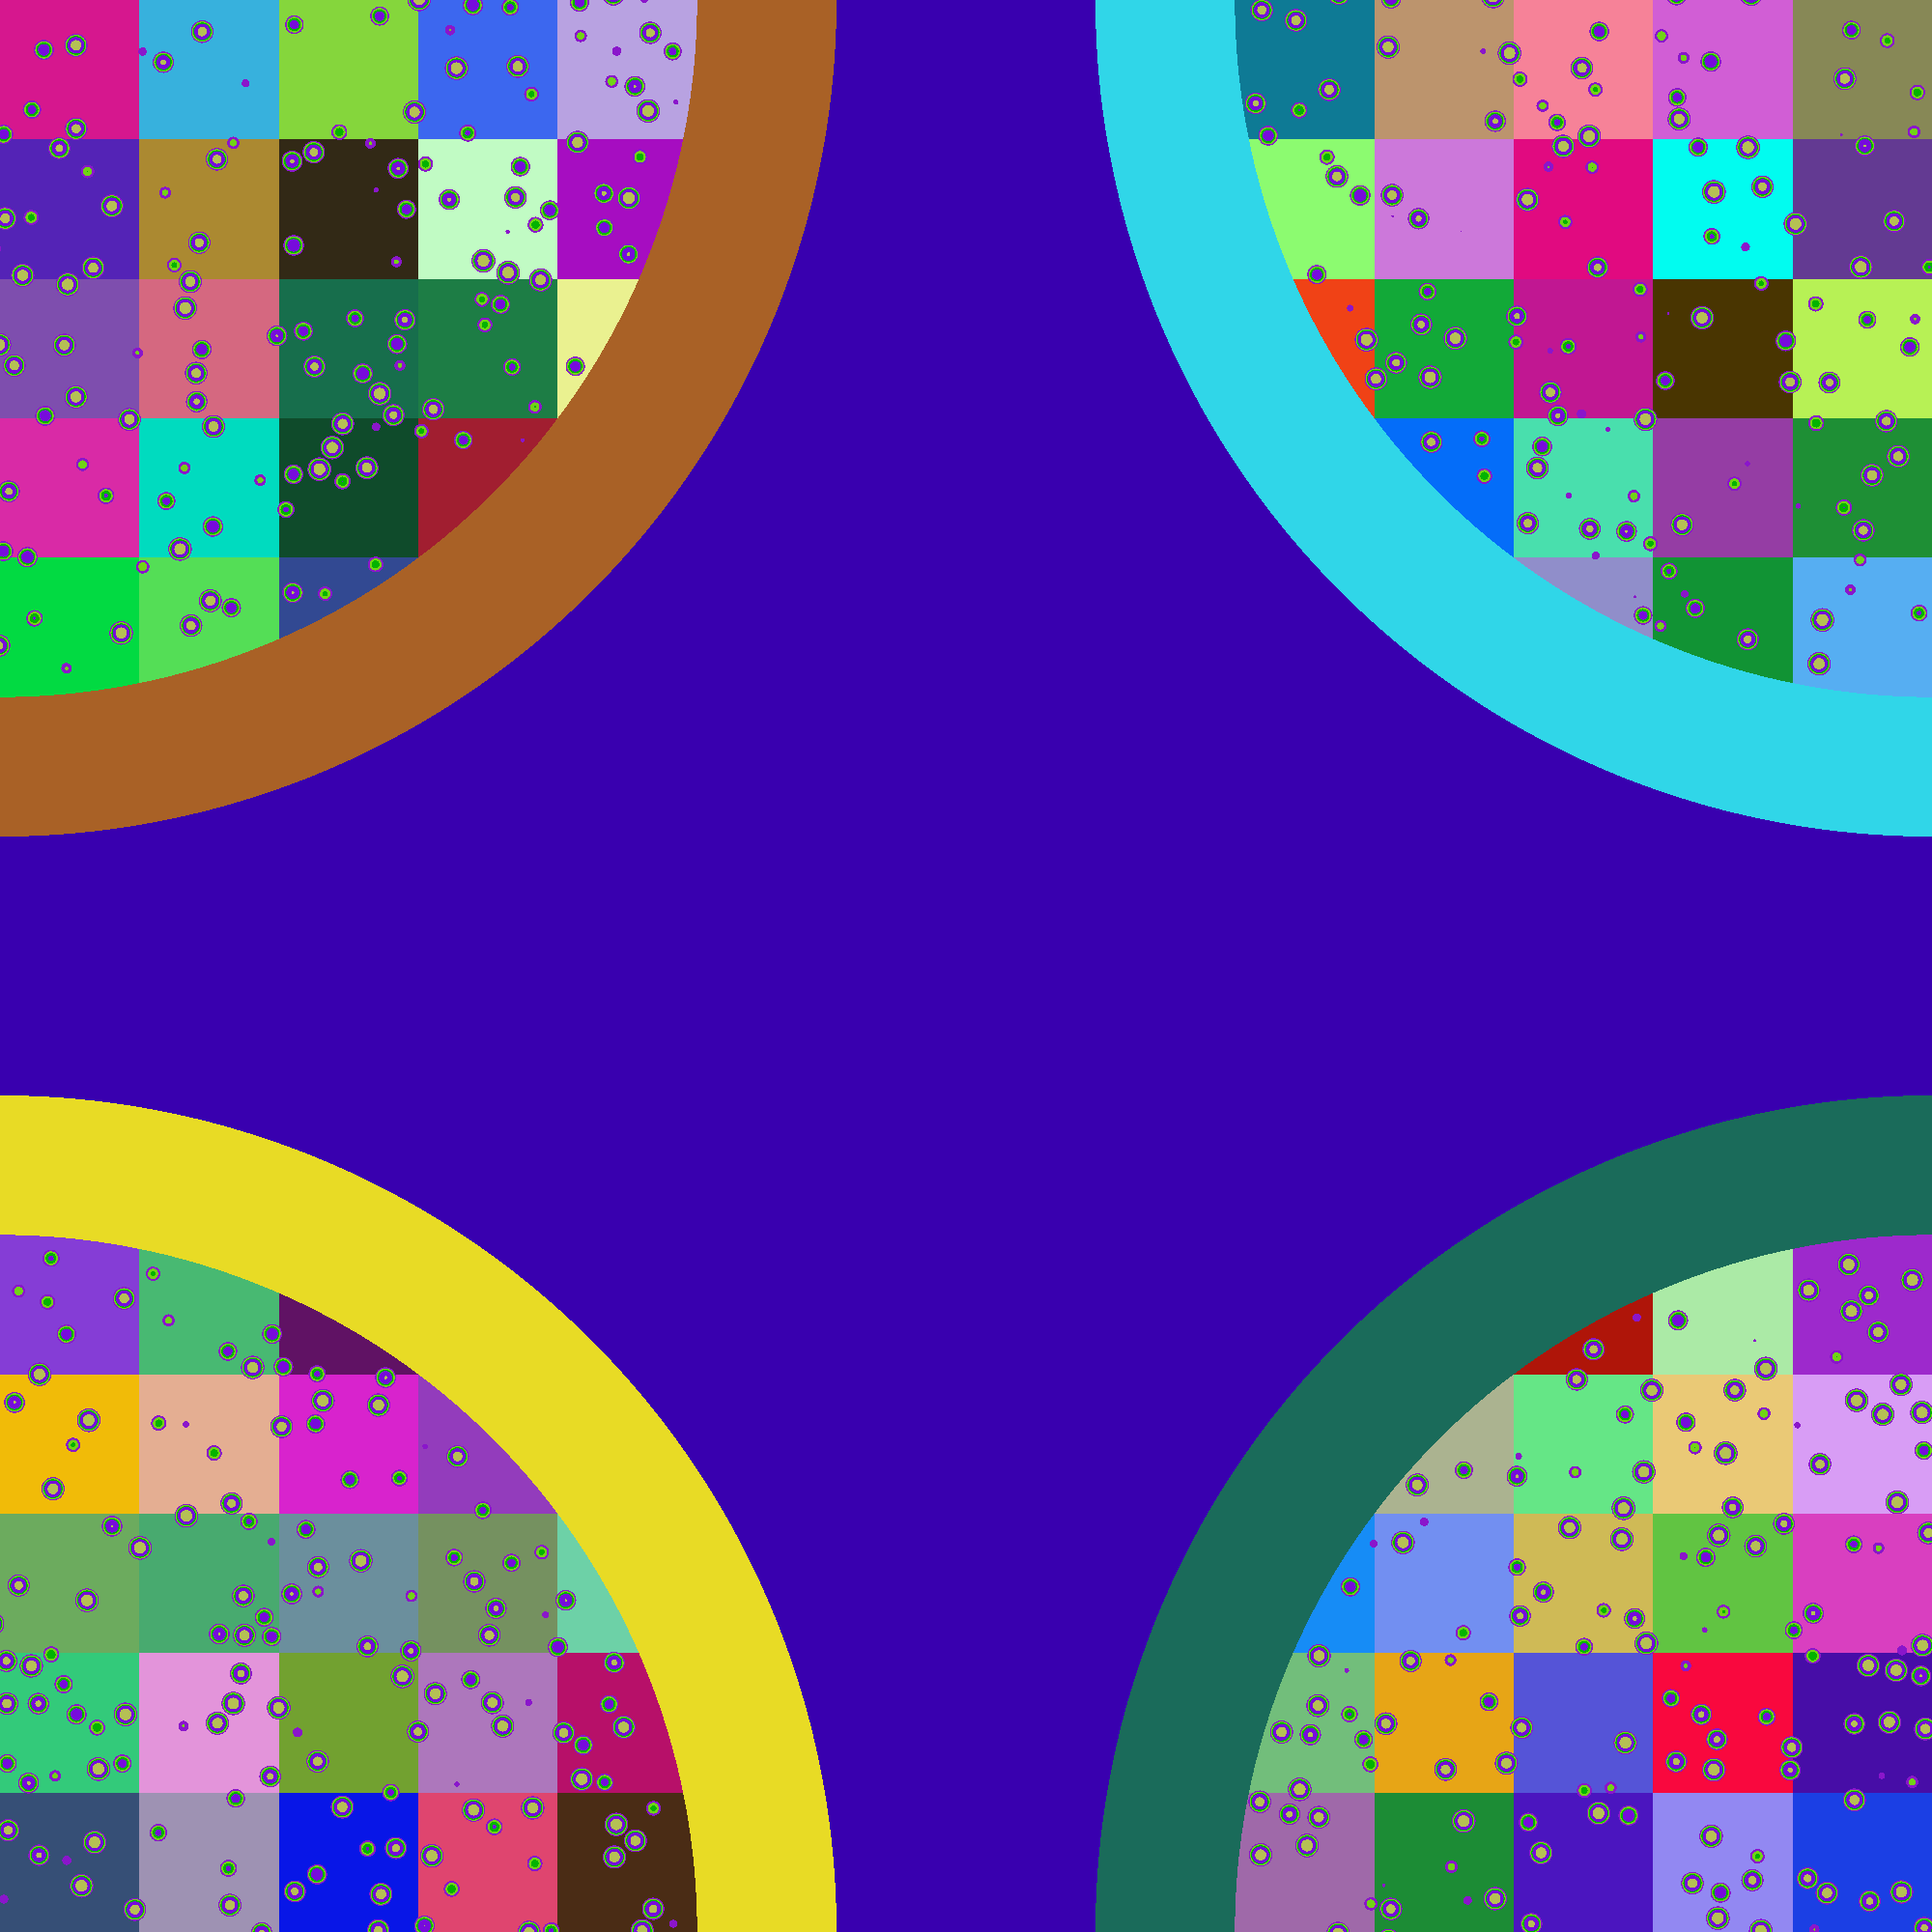

In [29]:
plot_cell_p5 = openmc.Plot.from_geometry(geometry)
plot_cell_p5.show_overlaps = True
plot_cell_p5.overlap_color = 'red'
plot_cell_p5.basis = 'yz'
plot_cell_p5.origin = (-0.4999*bcc_l, 0, 0)
plot_cell_p5.width = (bcc_l, bcc_l)
plot_cell_p5.pixels = (2000, 2000)
plot_cell_p5.filename = 'cell_-1_0_0.png'
openmc.plot_inline(plot_cell_p5)

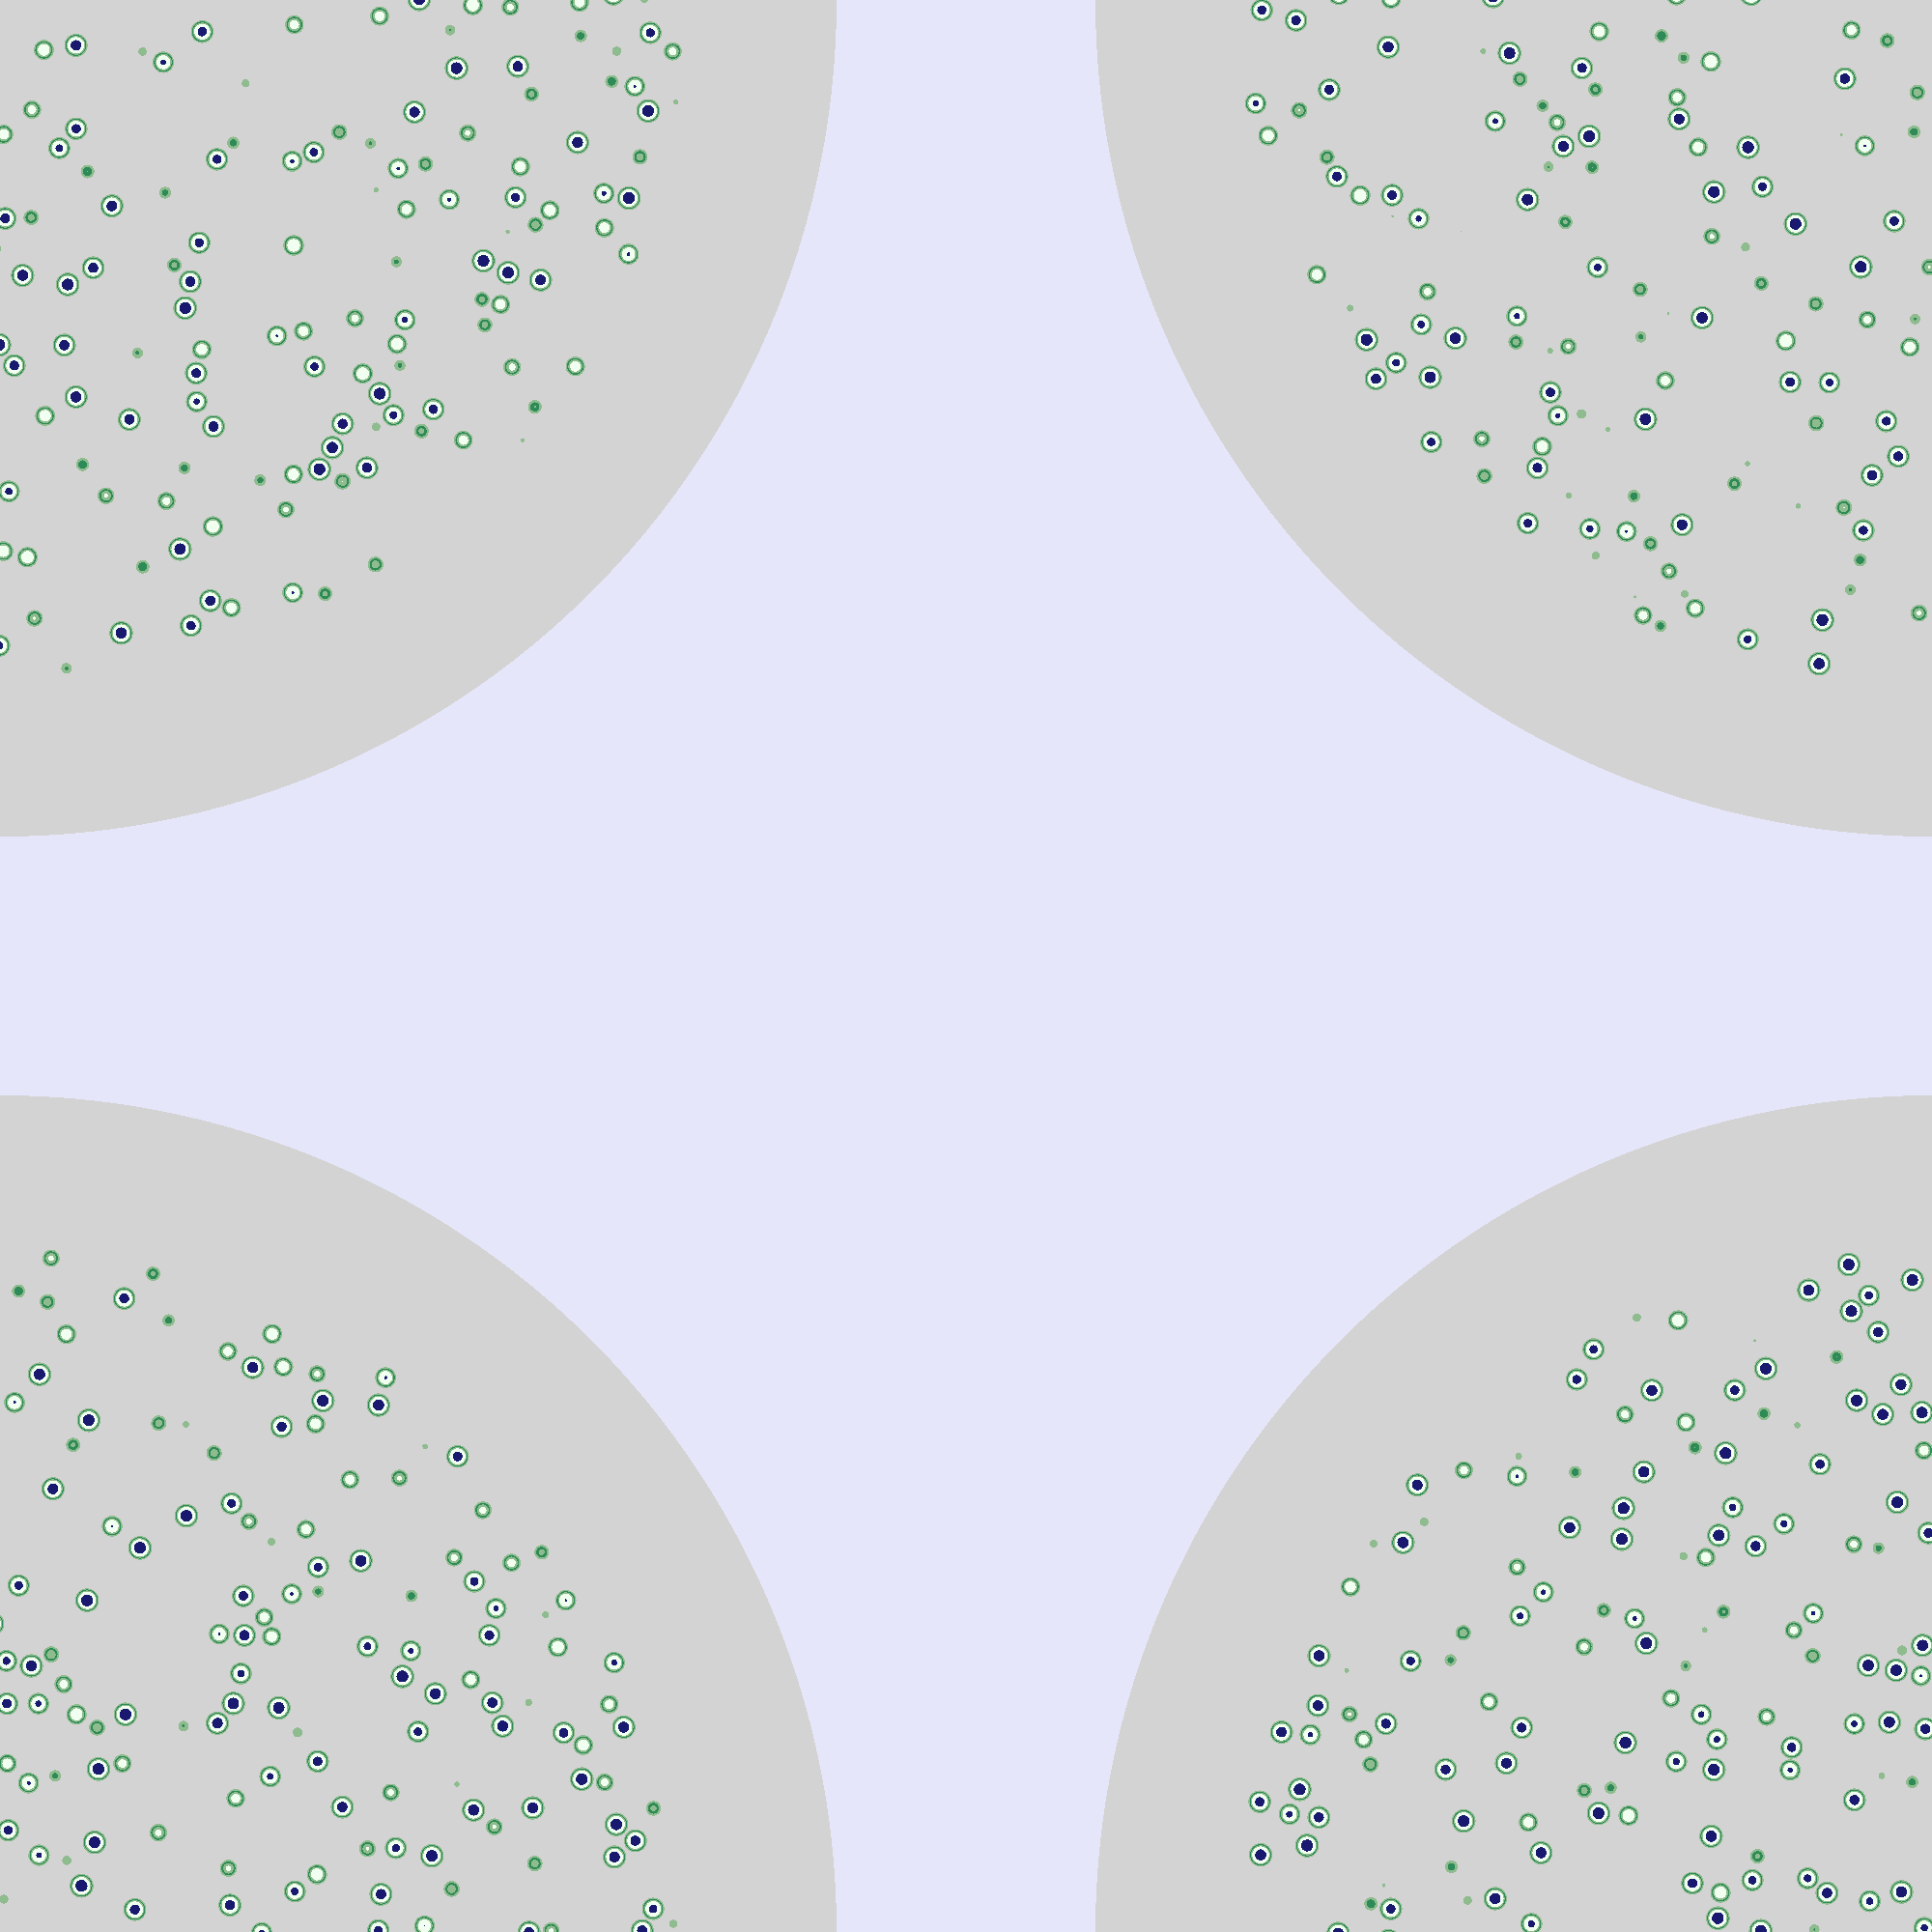

In [30]:
plot_mat_p5 = openmc.Plot.from_geometry(geometry)
plot_mat_p5.color_by = 'material'
plot_mat_p5.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_p5.basis = 'yz'
plot_mat_p5.origin = (-0.4999*bcc_l, 0, 0)
plot_mat_p5.width = (bcc_l, bcc_l)
plot_mat_p5.pixels = (2000, 2000)
plot_mat_p5.filename = 'mat_-1_0_0.png'
openmc.plot_inline(plot_mat_p5)

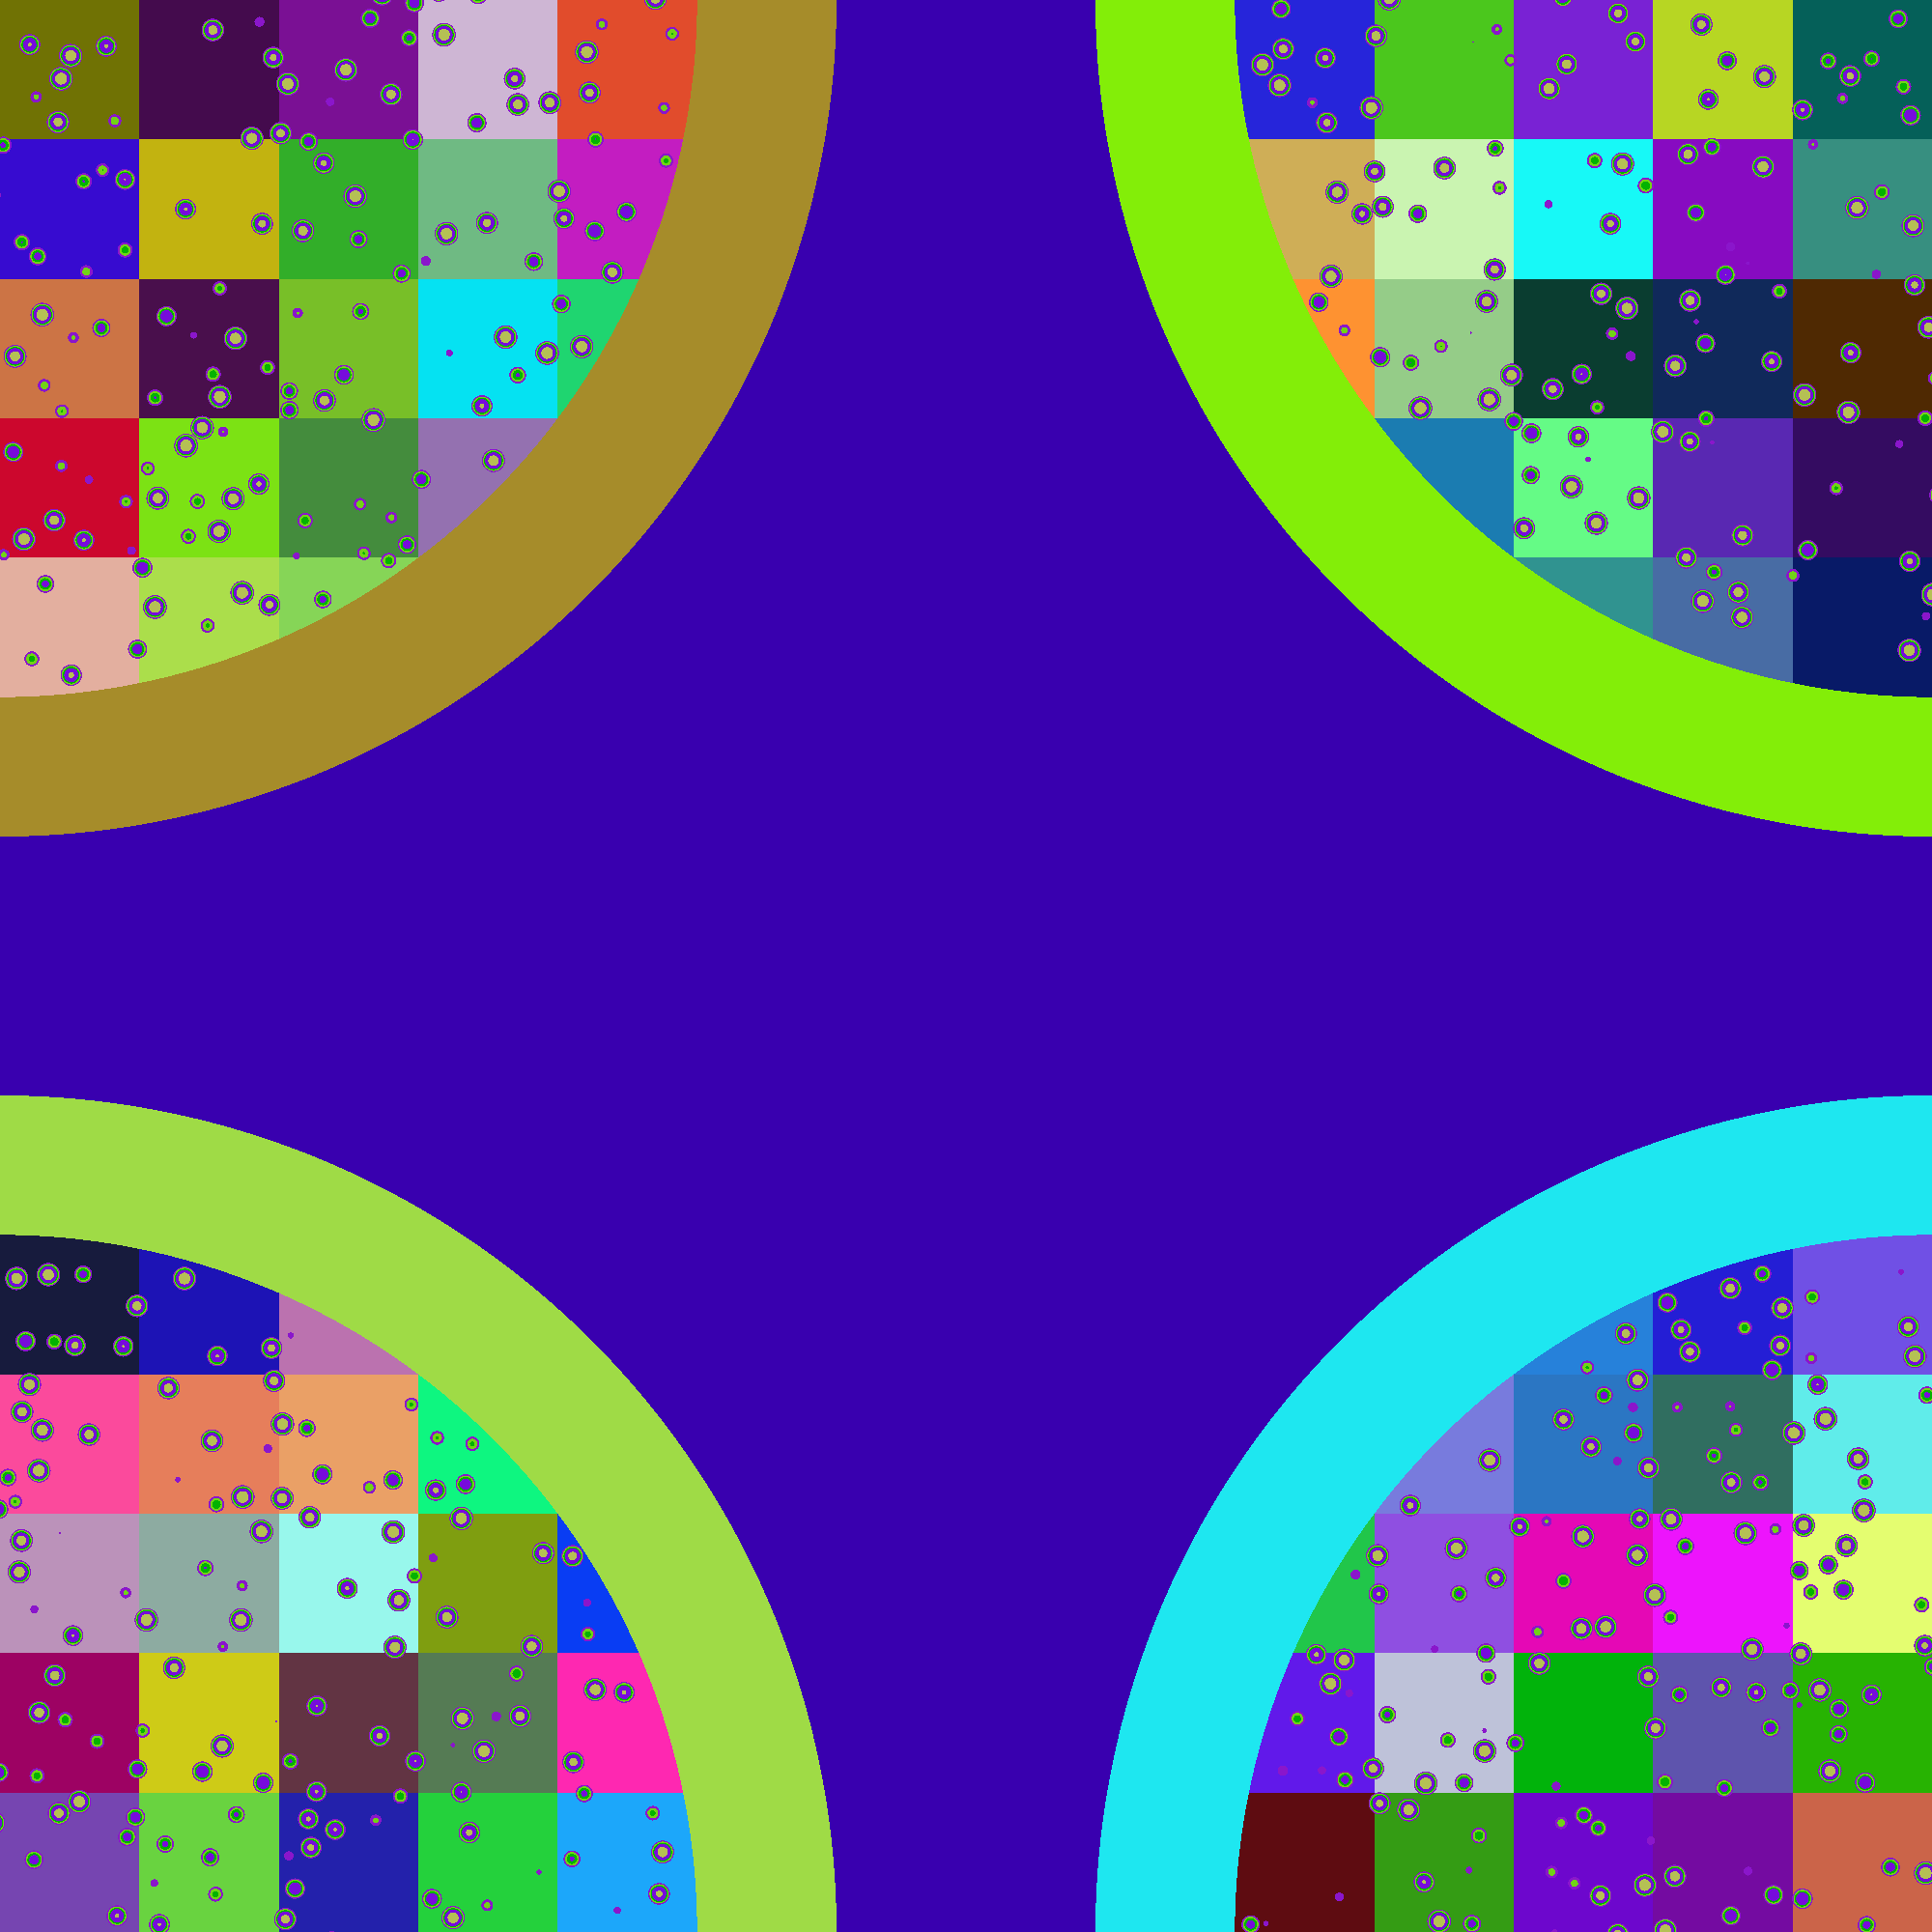

In [31]:
plot_cell_p6 = openmc.Plot.from_geometry(geometry)
plot_cell_p6.show_overlaps = True
plot_cell_p6.overlap_color = 'red'
plot_cell_p6.basis = 'yz'
plot_cell_p6.origin = (0.4999*bcc_l, 0, 0)
plot_cell_p6.width = (bcc_l, bcc_l)
plot_cell_p6.pixels = (2000, 2000)
plot_cell_p6.filename = 'cell_1_0_0.png'
openmc.plot_inline(plot_cell_p6)

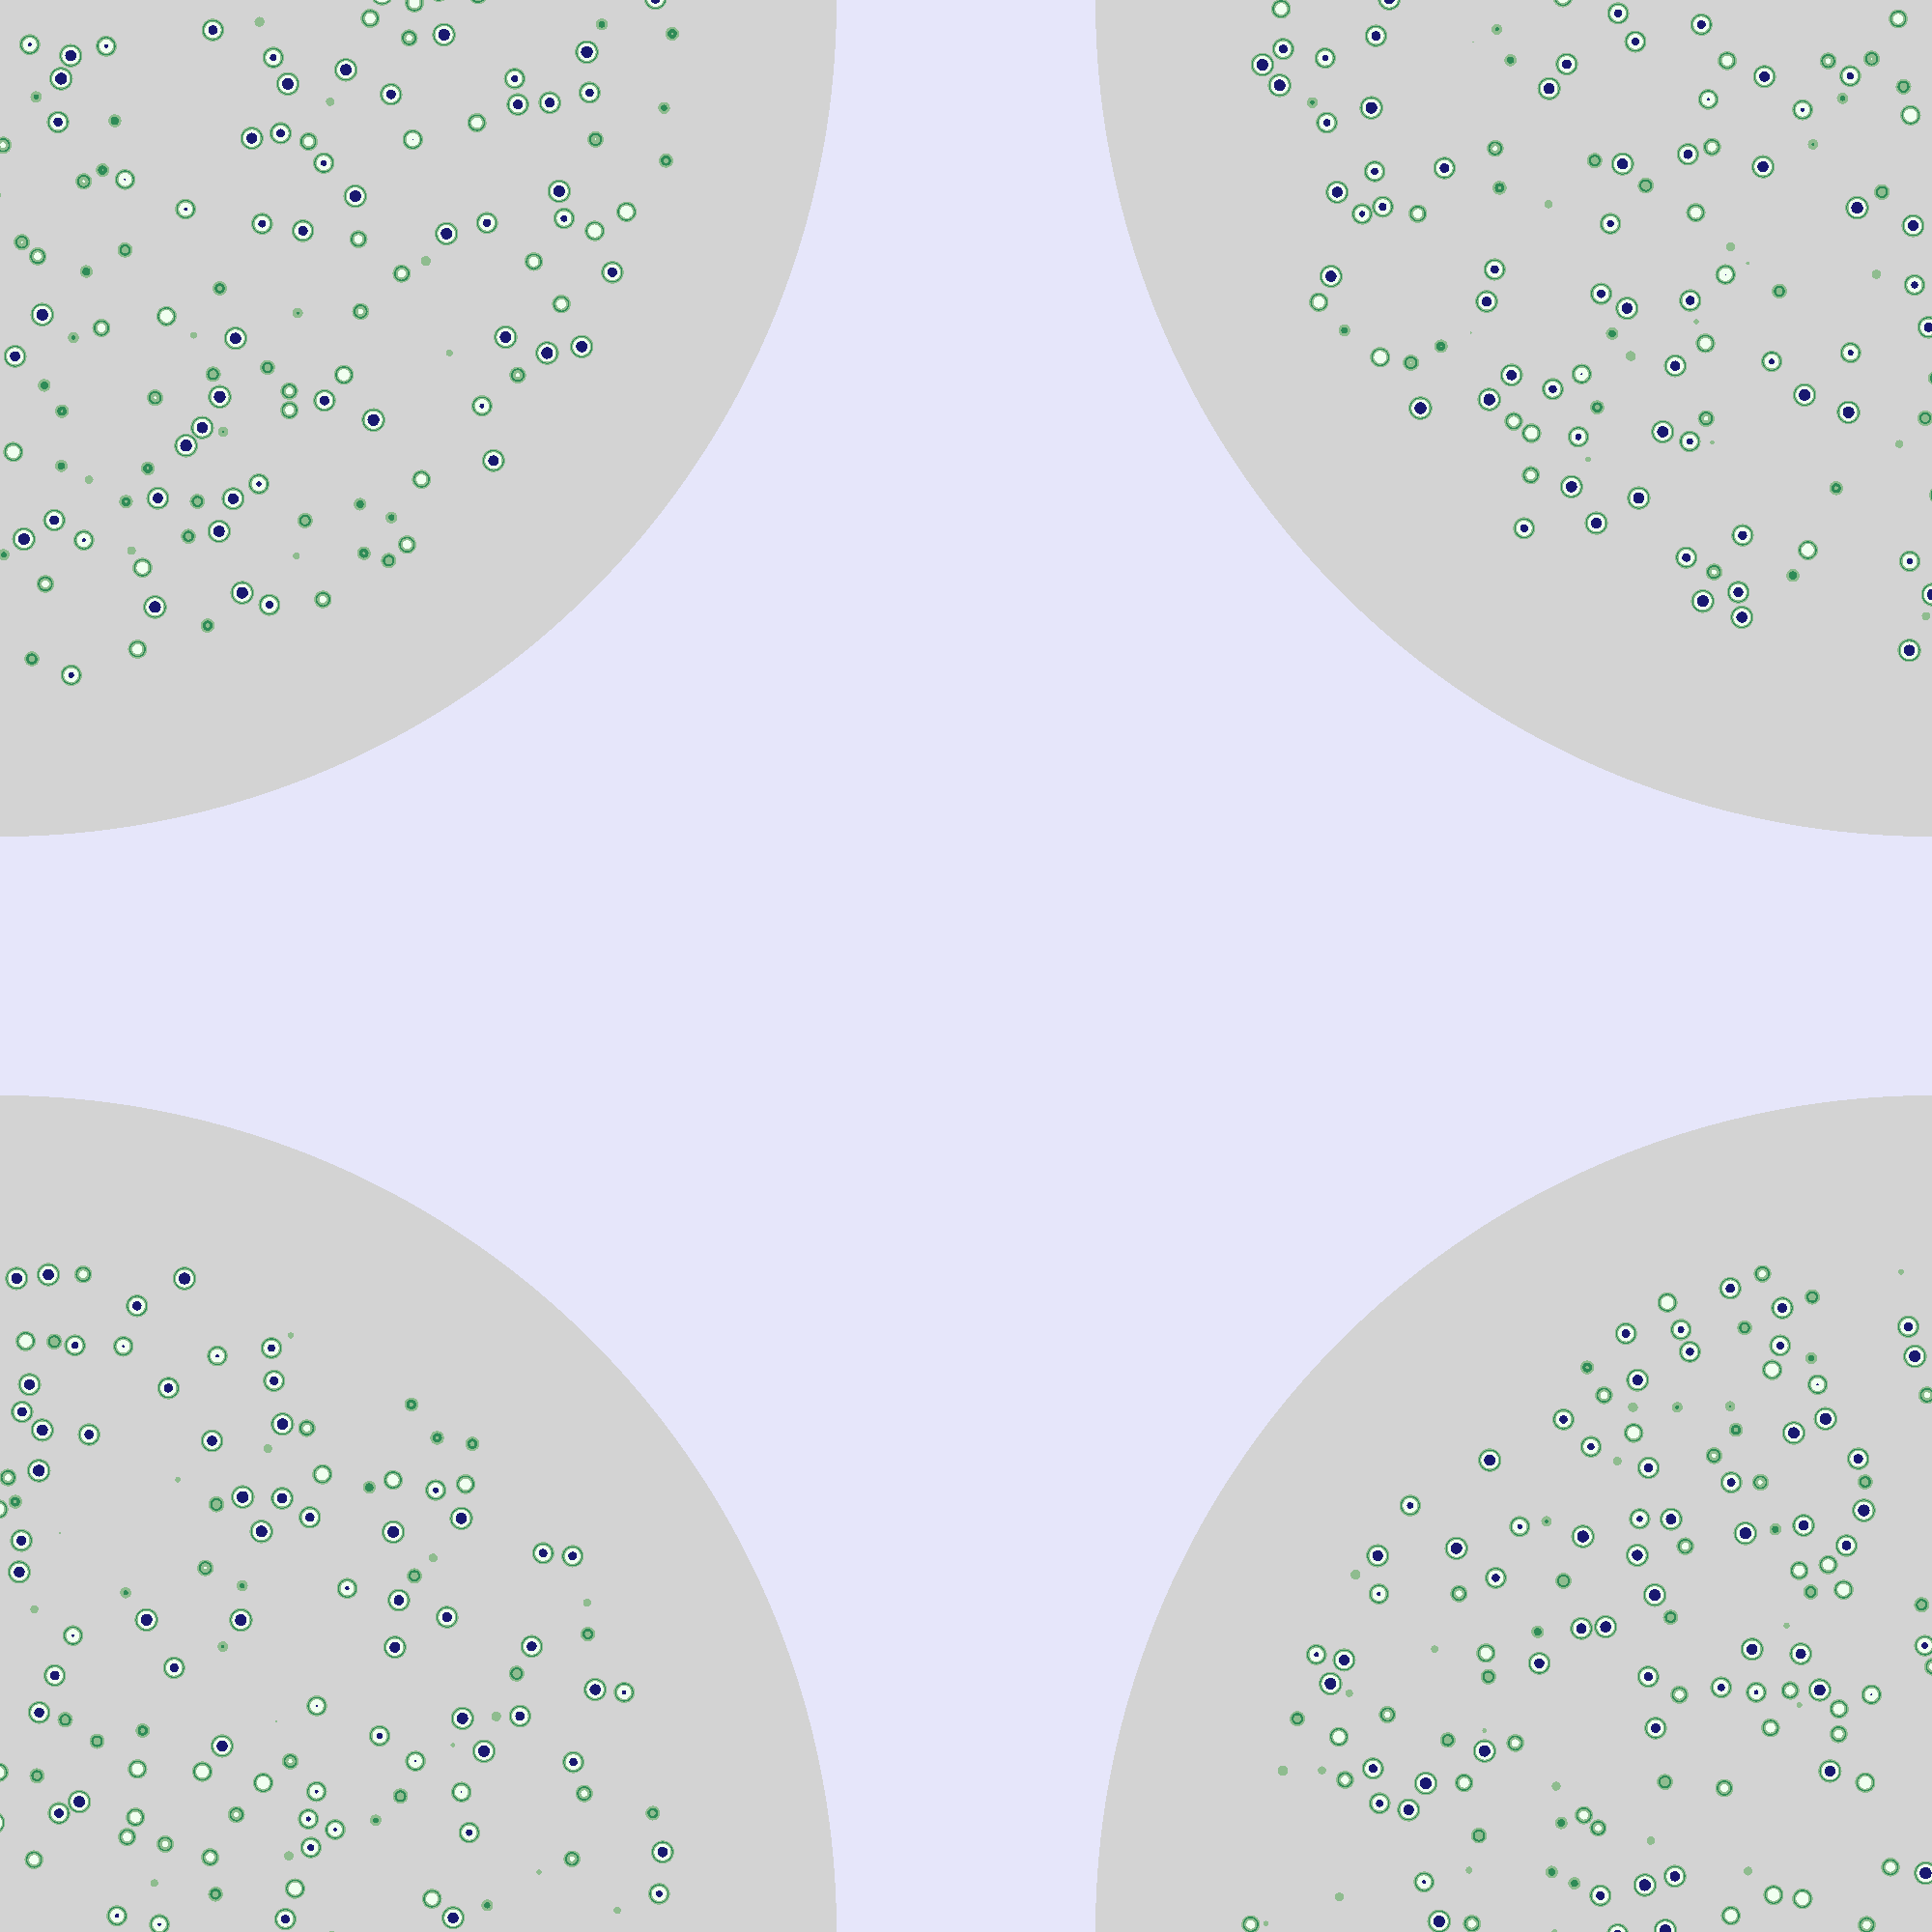

In [20]:
plot_mat_p6 = openmc.Plot.from_geometry(geometry)
plot_mat_p6.color_by = 'material'
plot_mat_p6.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
plot_mat_p6.basis = 'yz'
plot_mat_p6.origin = (0.4999*bcc_l, 0, 0)
plot_mat_p6.width = (bcc_l, bcc_l)
plot_mat_p6.pixels = (2000, 2000)
plot_mat_p6.filename = 'mat_1_0_0.png'
openmc.plot_inline(plot_mat_p6)

In [18]:
vox_plot = openmc.Plot()
vox_plot.type = 'voxel'
vox_plot.color_by = 'cell'
vox_plot.origin = (0.0, 0.0, 0.0)
vox_plot.width = (bcc_l, bcc_l, bcc_l)
vox_plot.pixels = (500, 500, 500)
vox_plot.filename = 'bcc.h5'
vox_plots = openmc.Plots([vox_plot])
vox_plots.export_to_xml()
openmc.plot_geometry()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [19]:
#vox_plot.to_vtk(output='bcc.vti')
openmc.voxel_to_vtk('bcc.h5', output='bcc.vti')

'bcc.vti'

In [18]:
ray_plot = openmc.SolidRayTracePlot()
ray_plot.colors = {graphite: 'lightgray', he: 'lavender', uco: 'midnightblue', pyc: 'darkseagreen', sic: 'seagreen', buffer:'honeydew'}
ray_plot.pixels = (2000, 2000)
ray_plot.camera_position = (bcc_l, bcc_l, 0.75*bcc_l)
ray_plot.look_at = (0.0, 0.0, 0.0)
ray_plot.color_by = 'material'
ray_plot.light_position = (2*bcc_l, 3*bcc_l, 4*bcc_l)
ray_plot.diffuse_fraction = 0.50
ray_plot.opaque_domains = [graphite, uco, pyc, sic, buffer]
ray_plot.filename = '3d-bcc-mat.png'

In [19]:
ray_plots = openmc.Plots([ray_plot])
ray_plots.export_to_xml()
openmc.plot_geometry()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
openmc.run(particles = 1000, geometry_debug=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################